In [47]:
library(cacoa)
library(Seurat)
library(magrittr)
library(cowplot)
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=10, jupyter.plot_scale = 1,repr.plot.res = 100)
Sys.setenv(https_proxy='http://www-int.dkfz-heidelberg.de:80')
Sys.setenv(http_proxy='http://www-int.dkfz-heidelberg.de:80')

if (exists("snakemake")) {
    cao_input <- snakemake@input[["cacoa_processed"]]
    repermute <- snakemake@params[["permute"]] 
    threads <- snakemake@threads
} else {
    base_fp <- "/omics/odcf/analysis/OE0228_projects/VascularAging/rna_sequencing/public_scrnaseq/TabularMuris/"
    cao_input <-  file.path(base_fp, "cao_obj_permute.RDS.gz")
    repermute <- F
}

# CACOA Analysis of 

In [48]:
cao_obj <- readRDS(cao_input)

In [49]:
estimateAllStabs <- function(cao_obj, de_n) {
    print(de_n)
    cao_obj$estimateDEStabilityPerCellType(top.n.genes = 300, de.name = de_n, 
                                     name = paste0(de_n,'_stab.fix'))

    cao_obj$estimateDEStabilityTrend(de.name = de_n, name = paste0(de_n, "_trend"),
                             top.n.genes = seq(50,500,50))  
    
    return(cao_obj)
}

#for(de_n in list("de.Wald", "deFixed_LRT", "de.fix", "de.loo")) {
 #   cao_obj <- estimateAllStabs(de_n = de_n, cao_obj = cao_obj)
#} 

[1] "de.Wald"
[1] "deFixed_LRT"
[1] "de.fix"
[1] "de.loo"


In [50]:
example.celltypes <- names(sort(table(cao_obj$cell.groups),decreasing=T))
top1 <- example.celltypes[1] 
top2 <- example.celltypes[c(1,2)]

cells.to.contour <- top2
cell.to.go <- example.celltypes[3]

alpha <- 0.1; size <- 0.1;

## Overview of dataset

UMAP visualization of the dataset stratified by age and by cell types

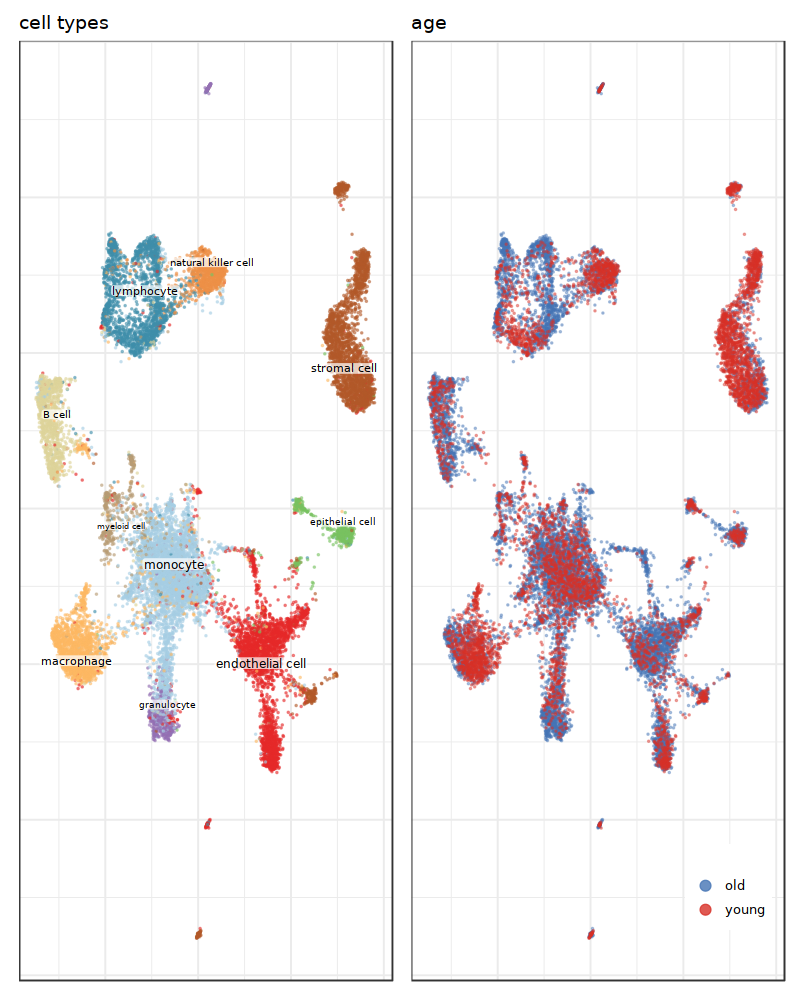

In [51]:
library(ggplot2)
library(patchwork)
size = 0.1
alpha = 0.5
cao_obj$plotEmbedding(color.by='cell.groups', alpha=alpha, size=size, title='cell types', 
                    plot.na=FALSE, show.legend=FALSE, font.size=c(2,3)) |
cao_obj$plotEmbedding(color.by='condition', alpha=0.4, size=0.1, title='age', mark.groups = F) +    theme(legend.position=c(0.85, 0.1)) +
    guides(color=guide_legend(override.aes = list(size=3,alpha=0.8),title='')) 

In [52]:
names(cao_obj$data.object@graphs)

[1] "SCT_nn"  "SCT_snn"

## Expresssion Shift Magnitudes

We can use Expression shift magnitudes to infer Intra- and Intercluster differences on the basis of Correlation distances between cells

The exact mechanisms are unclear. 



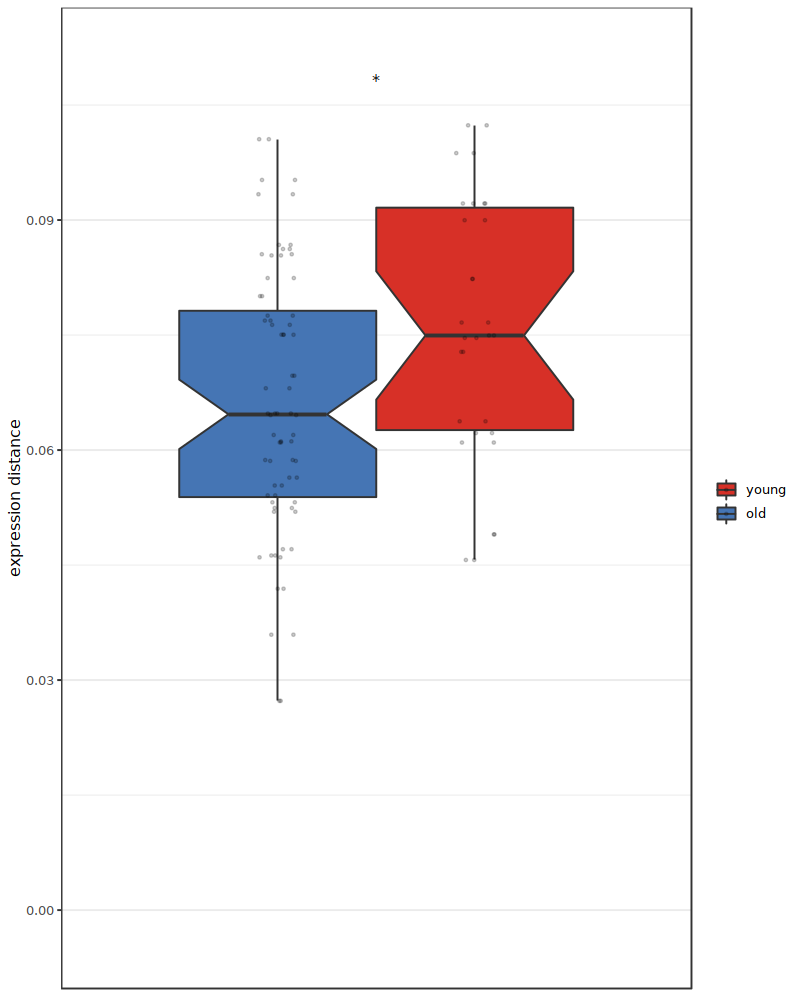

In [53]:
cao_obj$plotExpressionDistance(joint=TRUE, notch=TRUE, show.significance=TRUE)

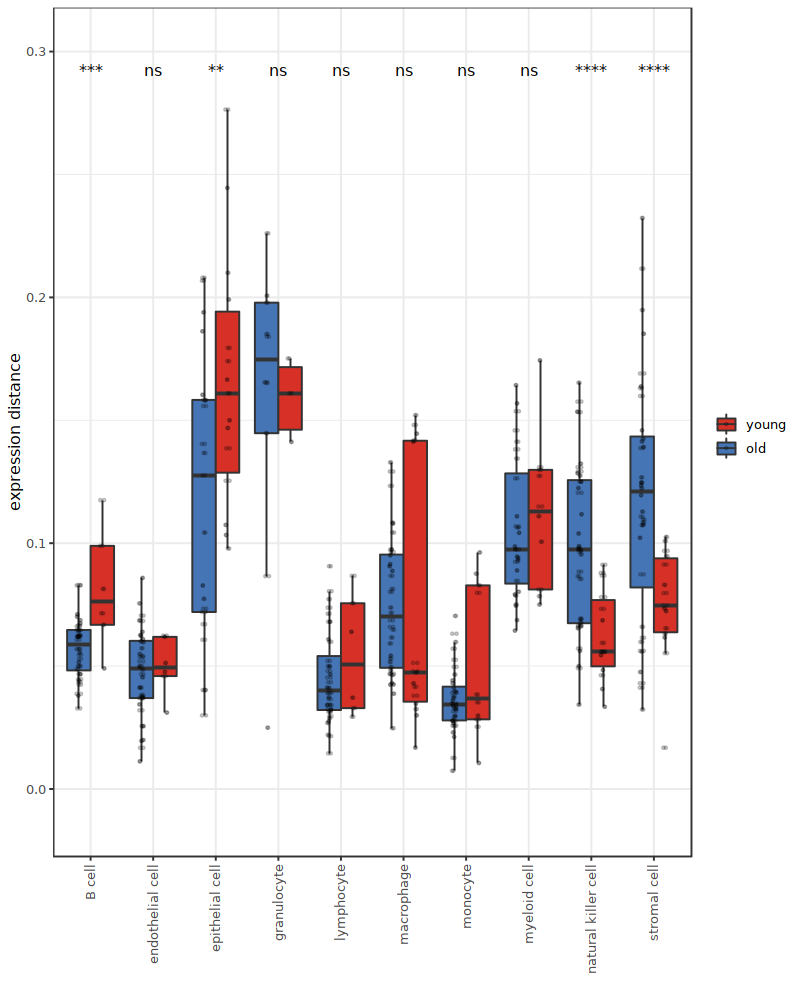

In [55]:
cao_obj$plotExpressionDistance(show.significance=TRUE)

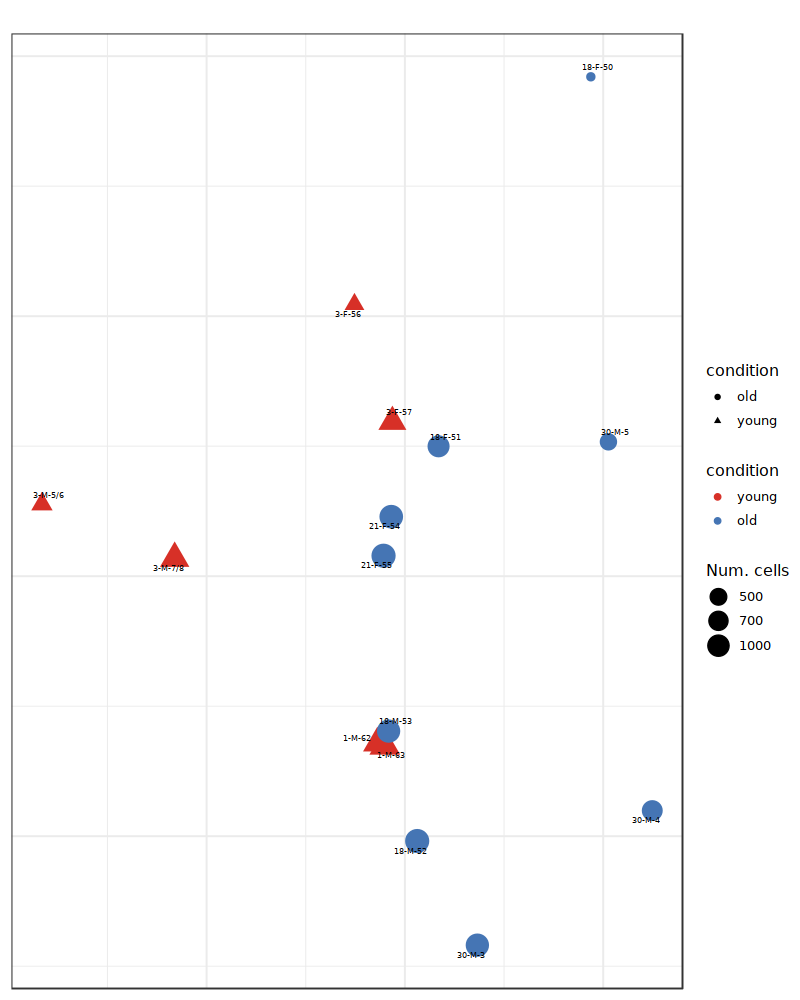

In [9]:
cao_obj$plotExpressionDistanceEmbedding(method='MDS', font.size=2)

### Shift types

The first plot here shows the ExpressionshiftMagnitude for "normal" expression shifts

The bottom plot shows this for "common" expression shifts. Difference between these two types is unknown. 


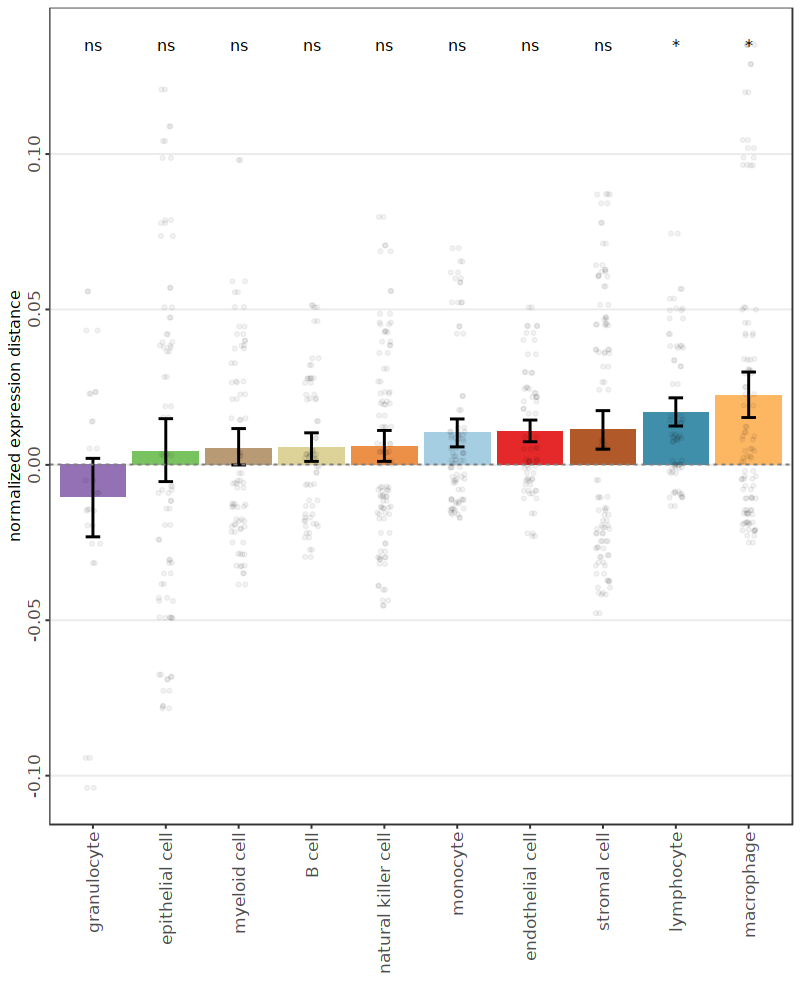

In [56]:
cao_obj$plotExpressionShiftMagnitudes(type='bar',show.pvalues = "adjusted",shift.type = "normal")

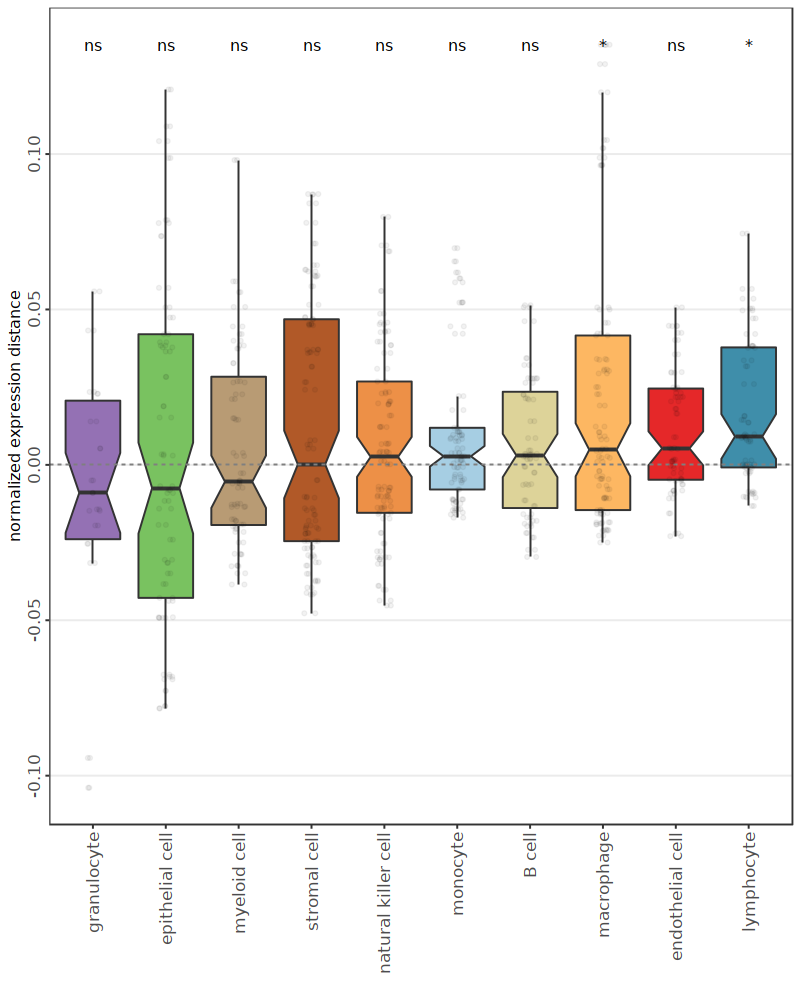

In [57]:
cao_obj$plotExpressionShiftMagnitudes()

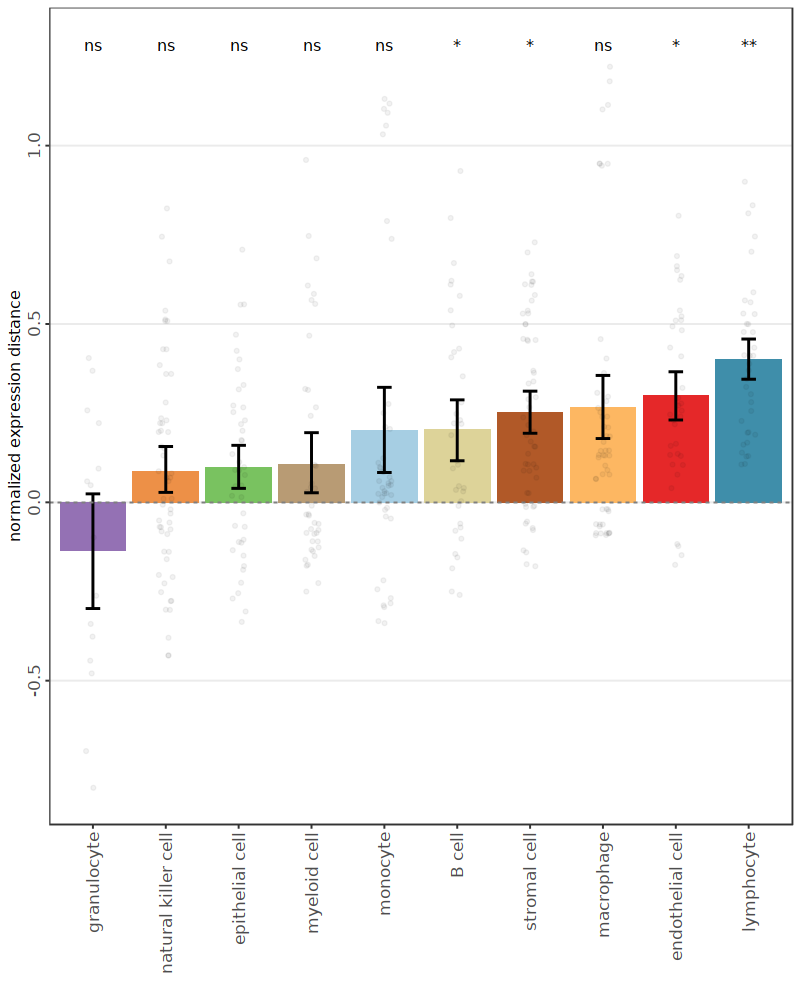

In [58]:
cao_obj$plotExpressionShiftMagnitudes(shift.type = "common", 
                                        show.jitter=TRUE, type='bar')

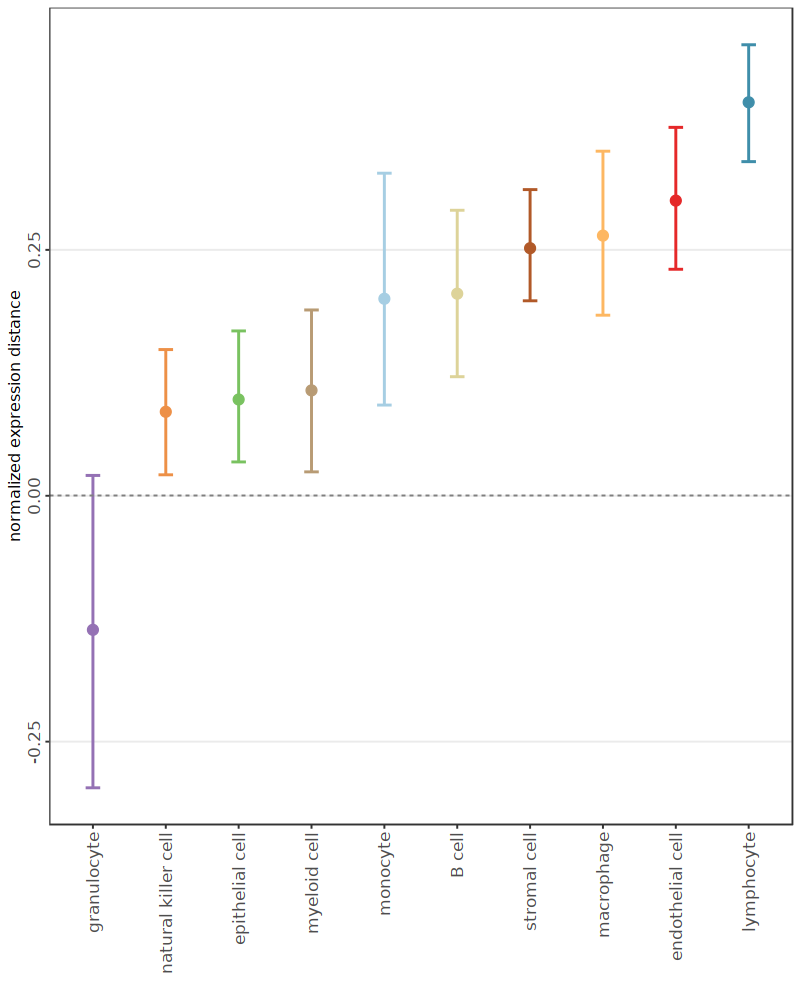

In [13]:
cao_obj$plotExpressionShiftMagnitudes( show.jitter=FALSE, type='point', shift.type = "common")

## Cell Group Proportions between groups

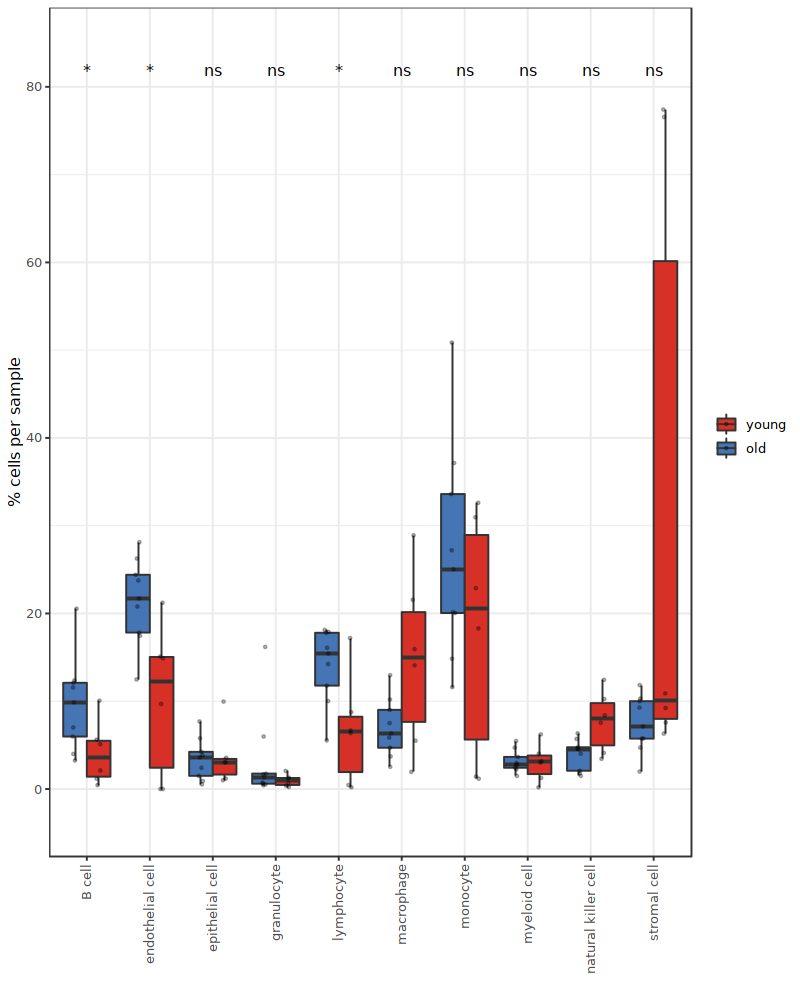

In [14]:
cao_obj$plotCellGroupProportions(alpha=0.3, show.significance=TRUE)

This plot shows PCA? Cell loadings to the best contrast? No Idea what this actually means but its pretty

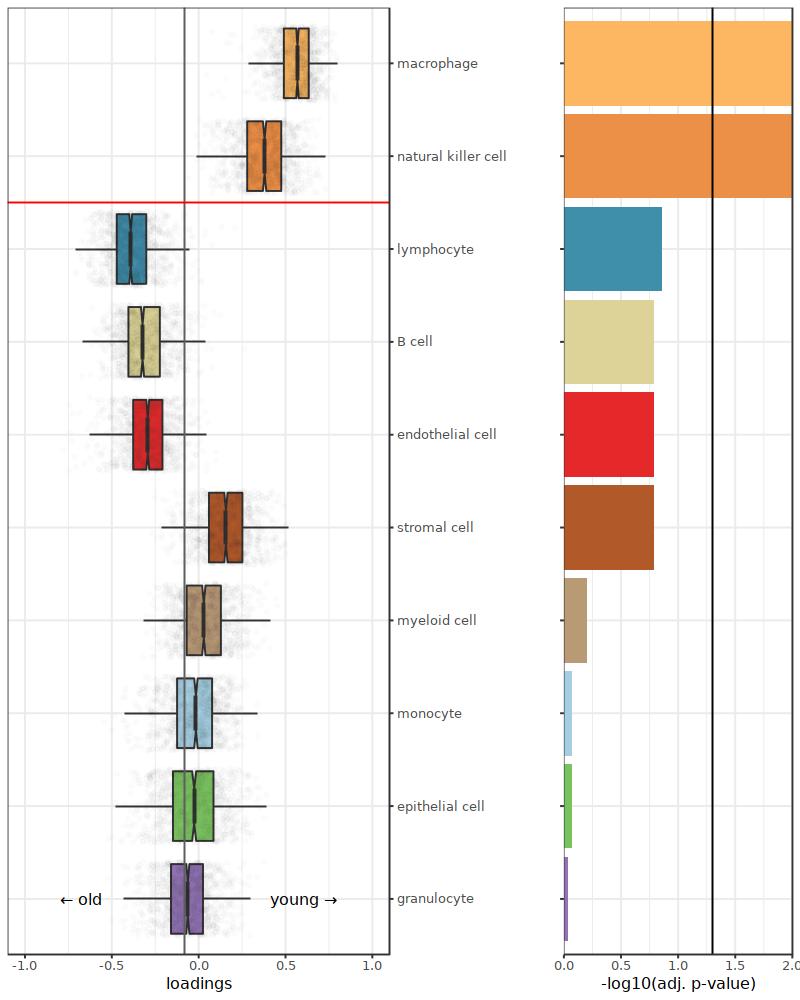

In [15]:
signif.threshold <- 0.05
cao_obj$plotCellLoadings(signif.threshold=signif.threshold, show.pvals=TRUE, alpha=0.01)

## CODA space

Sadly we dont know what CODA space is (some type of Dimensionality Reduction). The first plot is ont he basis of PCA and somehow infers cluster Positions across this PCA (But I can't really tell what and why)

The second plot uses significant cells from cda and does the same plot. Again no idea whwat when how and why. 


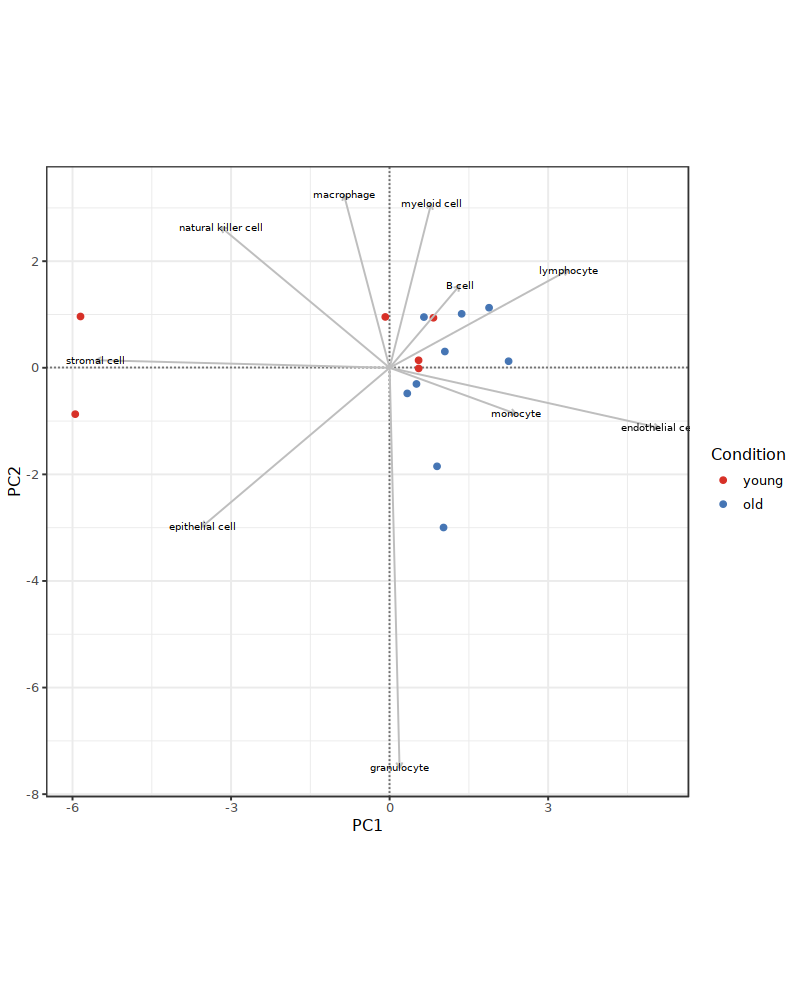

In [16]:

cao_obj$plotCodaSpace(space='PCA', font.size=2.5) 

In [17]:
cells.signif <- names(cao_obj$test.results$cda$pvals)[cao_obj$test.results$cda$pvals < signif.threshold]

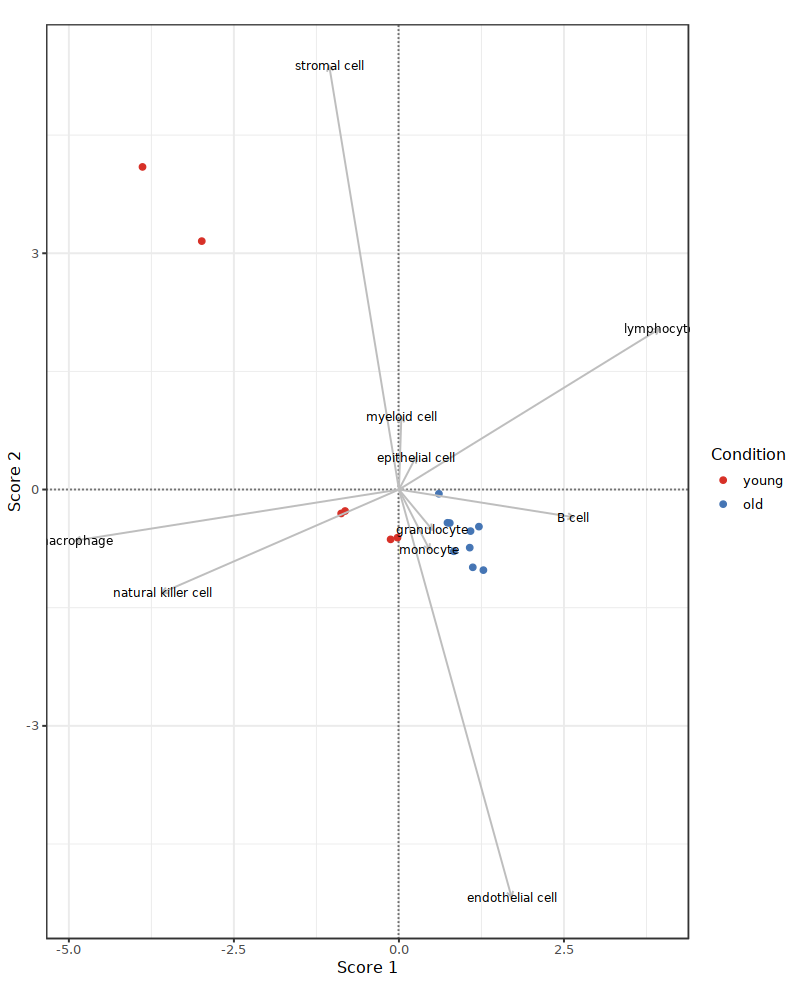

In [18]:
if(length(cells.signif) >= 2) {
 cao_obj$plotCodaSpace(space='CDA', cells.to.remain = cells.signif)
} else {
  cao_obj$plotCodaSpace(space='CDA')
}

[1] "up and down"


Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


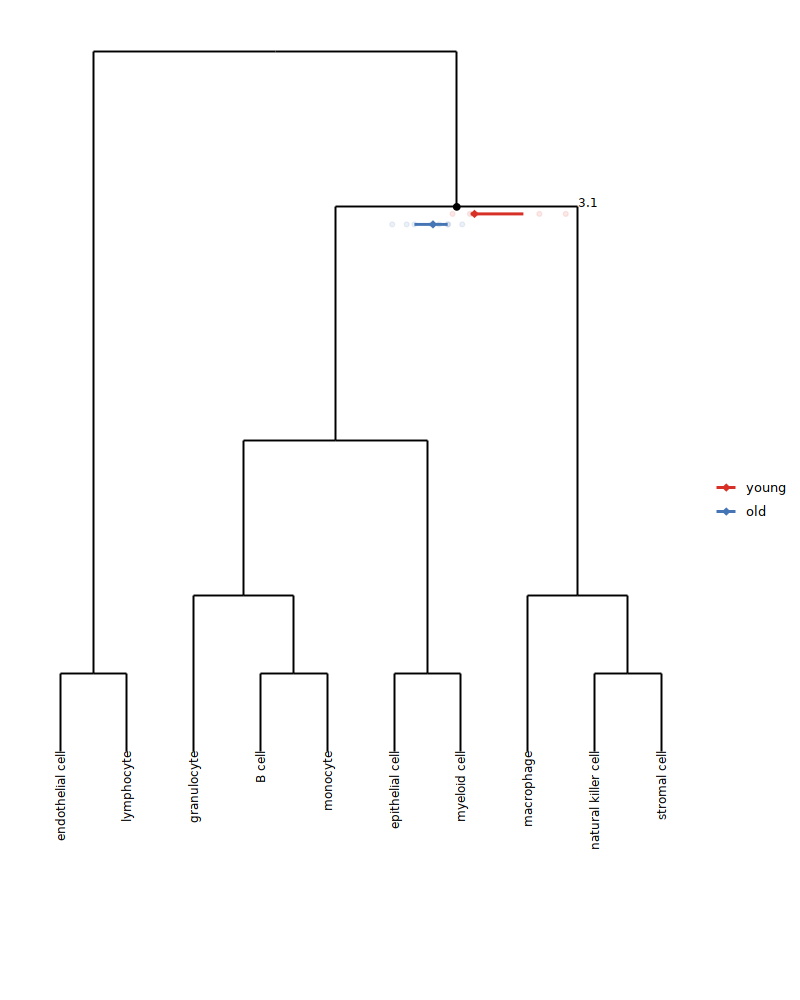

In [19]:
cao_obj$plotContrastTree()

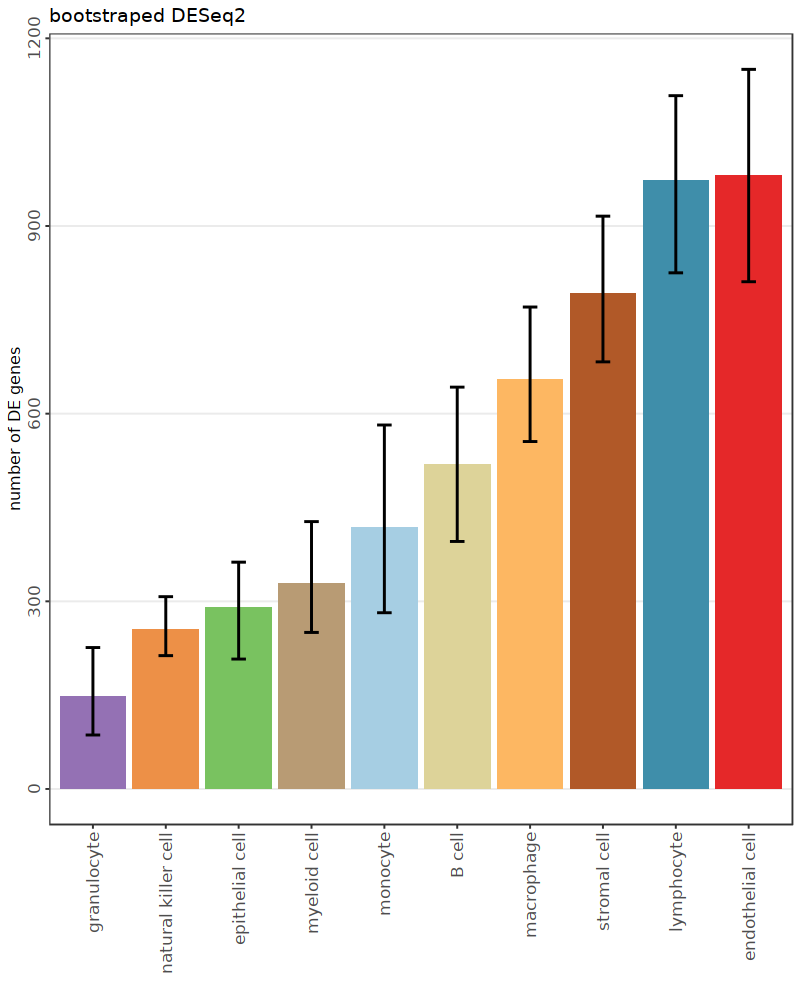

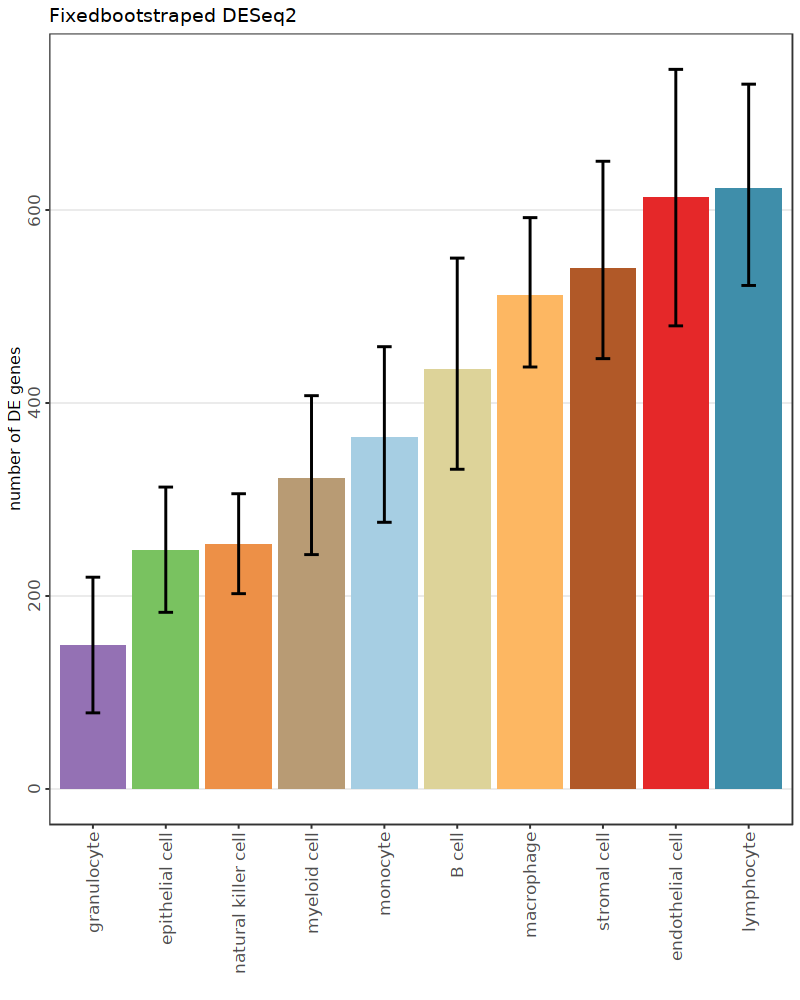

In [20]:
library(ggplot2)
cao_obj$plotNumberOfDEGenes(pvalue.cutoff=0.05, p.adjust=T, name = "de.Wald") +ggtitle("bootstraped DESeq2")
cao_obj$plotNumberOfDEGenes(pvalue.cutoff=0.05, p.adjust=T, name = "deFixed_LRT") +ggtitle("Fixedbootstraped DESeq2")

Warning message:
“Removed 3 rows containing missing values (geom_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


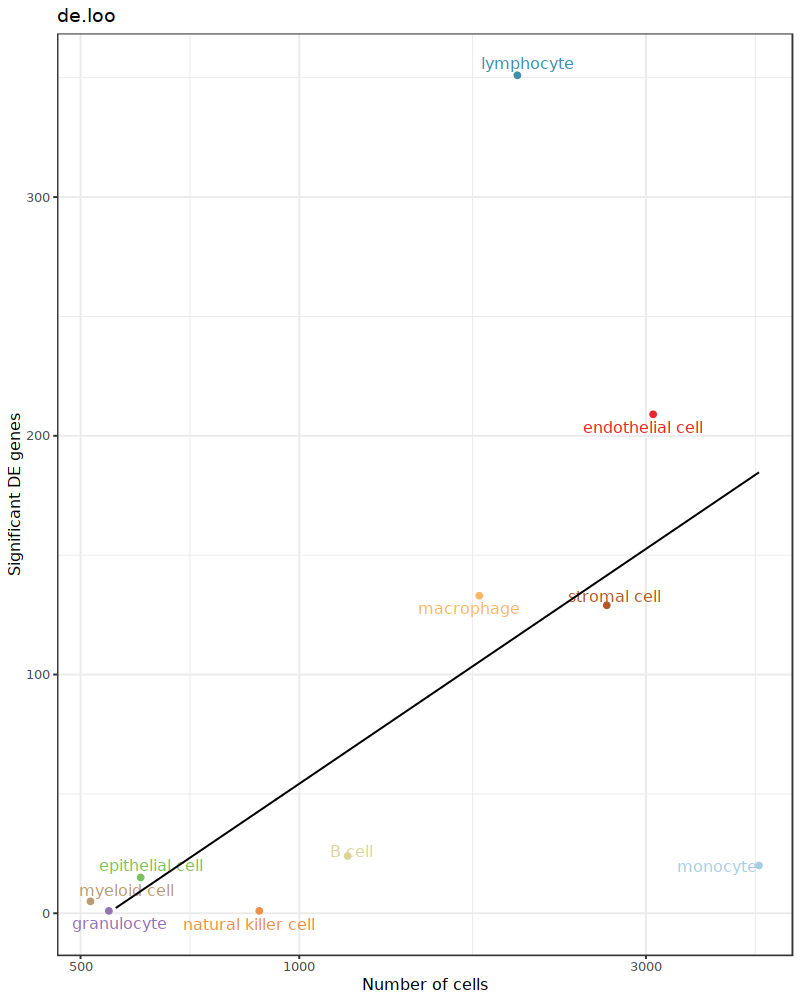

In [21]:
cao_obj$plotDEGenes(name = "de.loo") + ggplot2::ggtitle("de.loo")

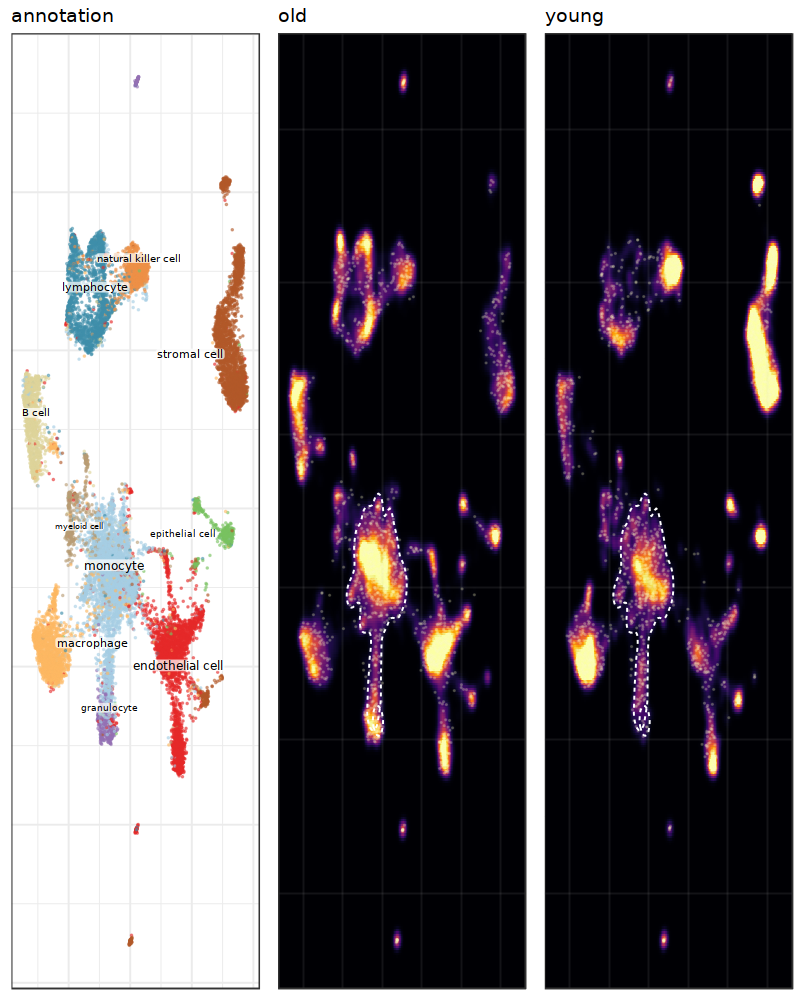

In [22]:

p0 <- cao_obj$plotEmbedding(color.by='cell.groups', alpha=alpha, size=size,
                        title='annotation', show.legend=FALSE, font.size=c(2,3))
pl <- cao_obj$plotCellDensity(add.points=TRUE, show.grid=TRUE, contours=cells.to.contour,
                          show.cell.groups=FALSE)
plot_grid(p0, plotlist=pl, nrow = 1)

In [23]:
#cao_obj$estimateDiffCellDensity(type='permutation', verbose=FALSE)
p1 <- cao_obj$plotDiffCellDensity(type='permutation', title='difference',
                              legend.position=c(0,0), contours=cells.to.contour)
#p2 <- cao_obj$plotDiffCellDensity(type='t.test', title='t.test',
     #                         legend.position=c(0,0), contours=cells.to.contour)
#p3 <- cao_obj$plotDiffCellDensity(type='wilcox', title='wilcox',
 #                             legend.position=c(0,0), contours=cells.to.contour)
#p4 <- cao_obj$plotDiffCellDensity(type='permutation', title='permutation',
 #                             legend.position=c(0,0), contours=cells.to.contour)

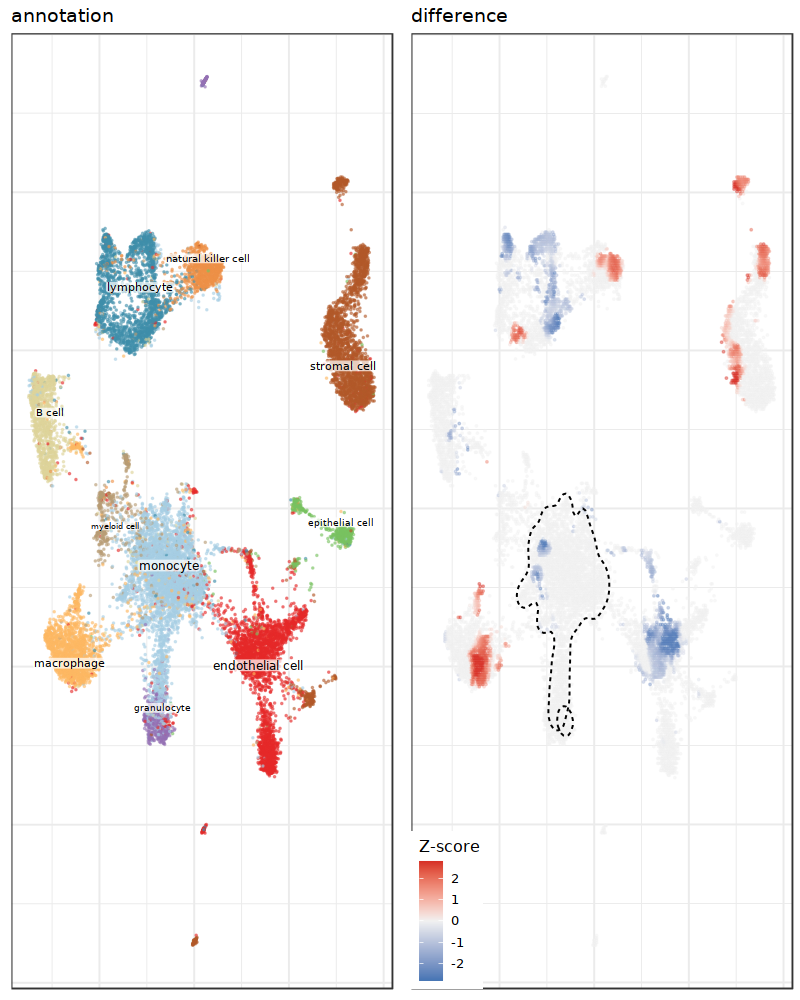

In [24]:
plot_grid(p0,p1)

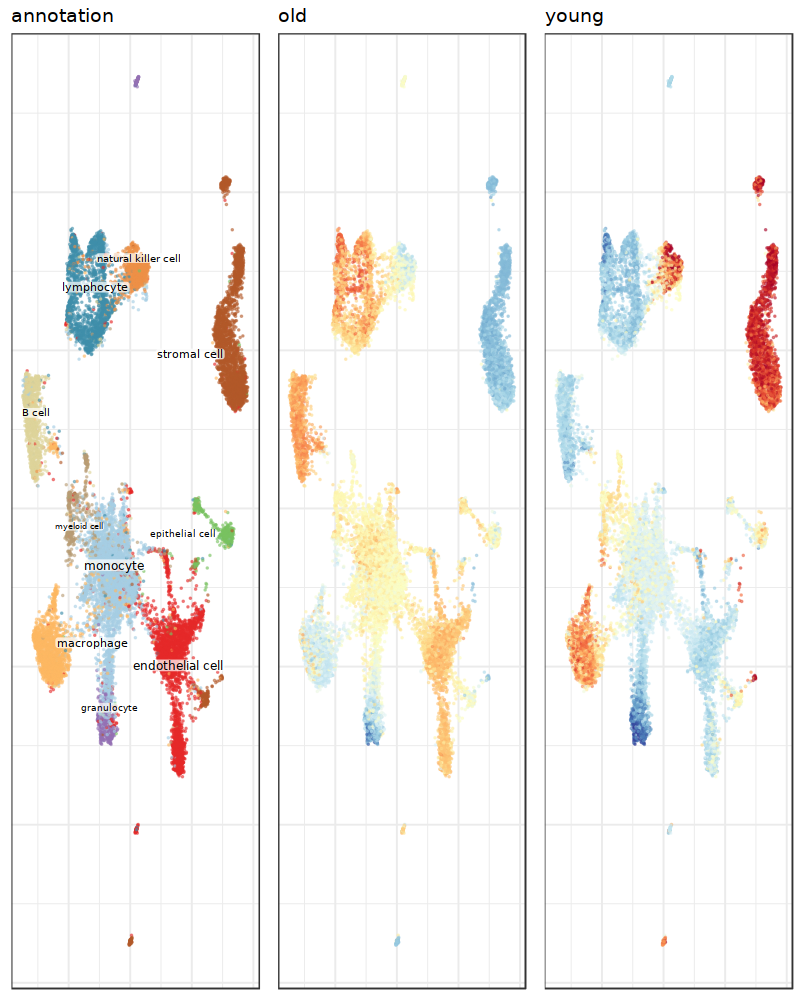

In [25]:
cao_obj$estimateCellDensity(method='graph', name='cell.density.graph',)
pl <- cao_obj$plotCellDensity(show.cell.groups=FALSE, name='cell.density.graph', size=size,
                          alpha=alpha, palette=brewerPalette("RdYlBu"))
plot_grid(p0, plotlist=pl, nrow=1)

In [26]:
cao_obj$estimateDiffCellDensity(type='permutation', verbose=FALSE, name='cell.density.graph')
ps <- lapply(c('permutation'), function(n) {
  cao_obj$plotDiffCellDensity(type=n, title=n, legend.position=c(0,0),
                          name='cell.density.graph', size=size, alpha=alpha,
                          gradient.range.quantile=0.975)
})

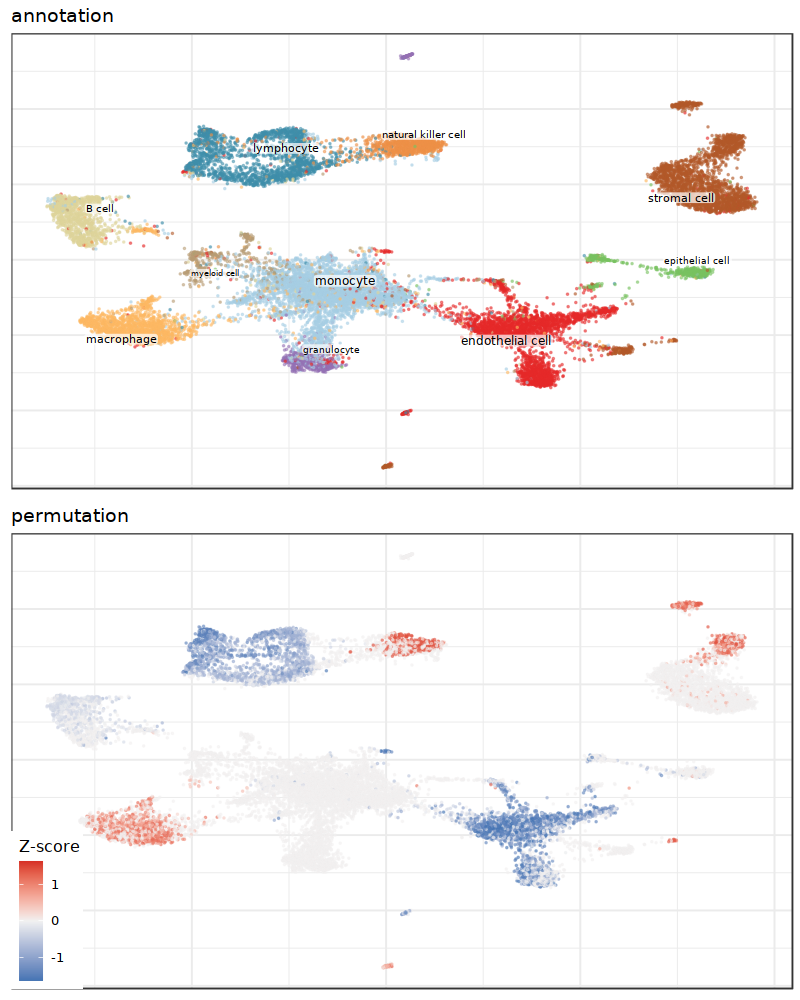

In [27]:
plot_grid(p0, plotlist=ps, nrow=2)

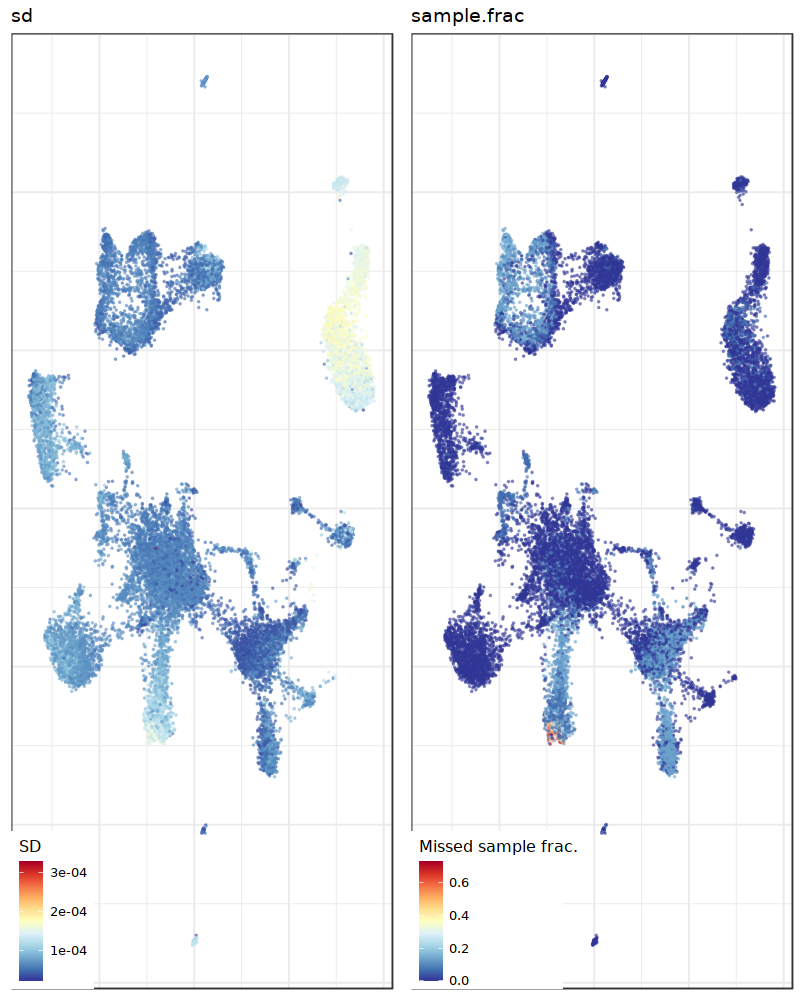

In [28]:
lapply(c('sd', 'sample.frac'), function(n) {
  cao_obj$plotCellDensityVariation(type=n, title=n, name='cell.density.graph', size=size,
                               alpha=alpha, palette=brewerPalette("RdYlBu"),
                               legend.position=c(0, 0))
}) %>% plot_grid(plotlist=., ncol=2)

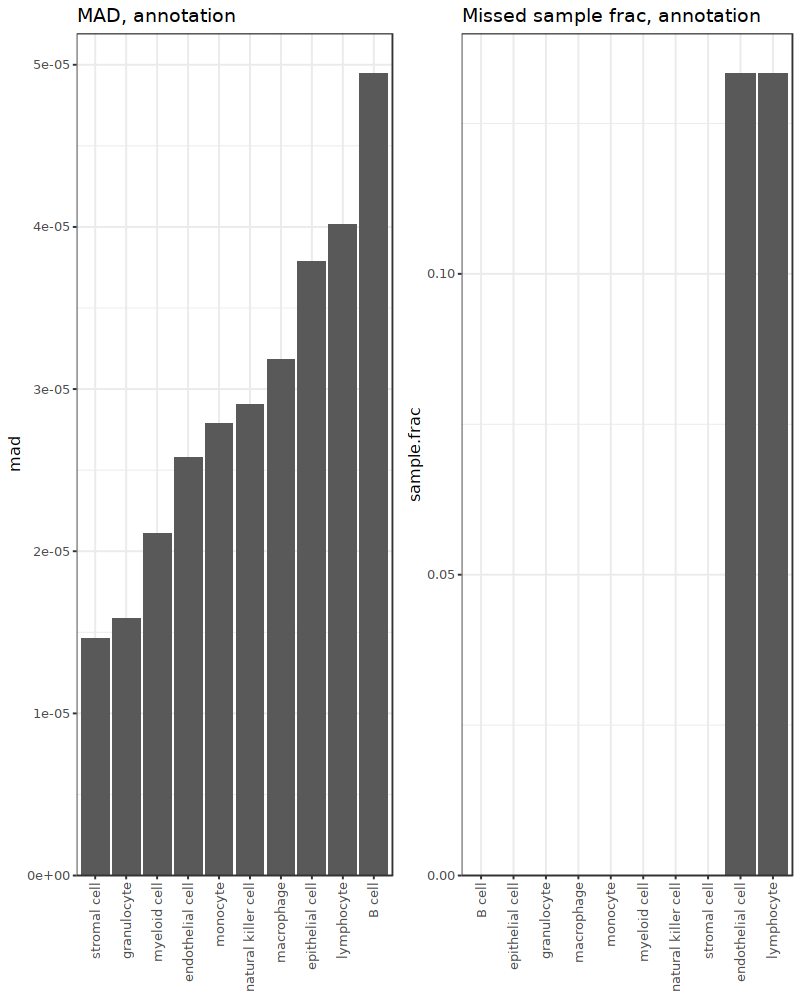

In [29]:
plot_grid(
  cao_obj$plotCellGroupAbundanceVariation() + ggtitle("MAD, annotation"),
  cao_obj$plotCellGroupAbundanceVariation(type='sample.frac') + ggtitle("Missed sample frac, annotation"),
  rel_heights=c(1, 0.7)
)

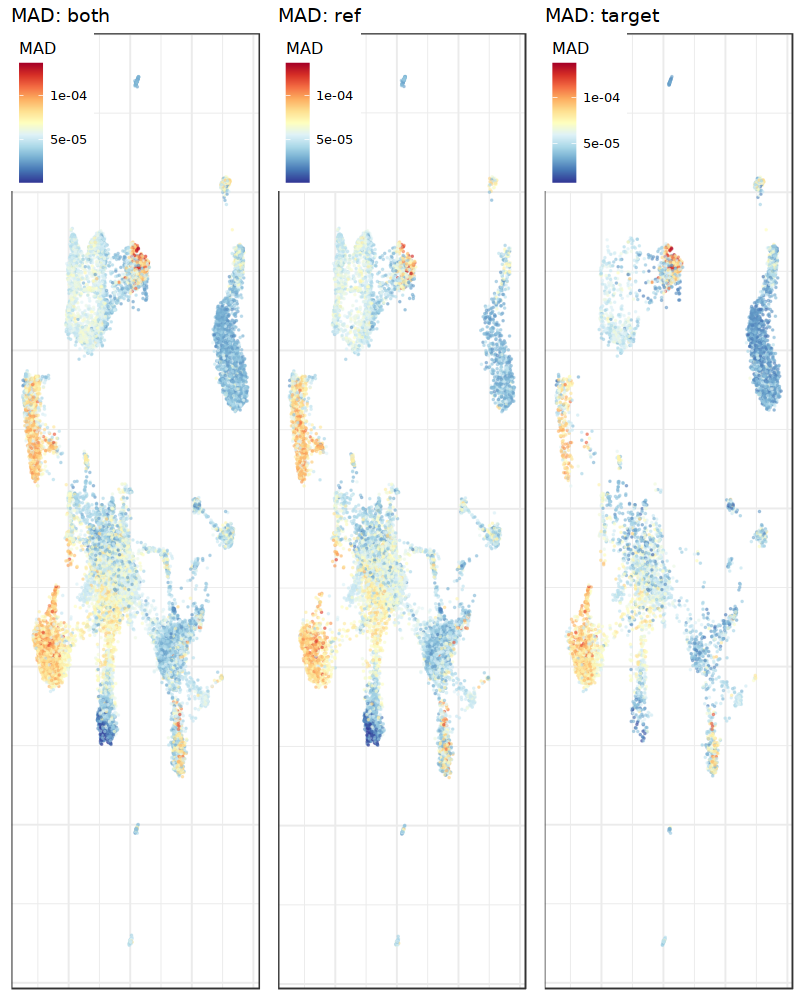

In [30]:
lapply(c('both', 'ref', 'target'), function(n) {
  cao_obj$plotCellDensityVariation(type='mad', condition=n, title=paste0('MAD: ', n), name='cell.density.graph',
                               size=size, alpha=alpha, palette=brewerPalette("RdYlBu"),
                               legend.position=c(0, 1))
}) %>% plot_grid(plotlist=., ncol=3)

In [31]:
#cao_obj$plotVolcano(xlim=c(-3, 3), ylim=c(0, 3), lf.cutoff=1)

In [32]:
#cao_obj$plotFilteredDEGenes(padj.cutoff = 0.05)

In [33]:
exc.genes <- cao_obj$test.results$cluster.free.z %>%  colnames() %>%
  .[grepl("Mt-", .)] %>% c("Malat1")
cao_obj$smoothClusterFreeZScores(n.top.genes=1000, progress.chunks=10, excluded.genes=exc.genes)

Smoothing Z-scores for 1000 genes passed filtration



In [34]:
p1 <- cao_obj$plotMostChangedGenes(15, legend.position=c(0, 1), size=size, alpha=alpha,
                         excluded.genes=exc.genes, min.z=2.0, max.z=20, max.z.plot=5,
                         plot.na=FALSE)

In [35]:
exc.genes

[1] "Malat1"

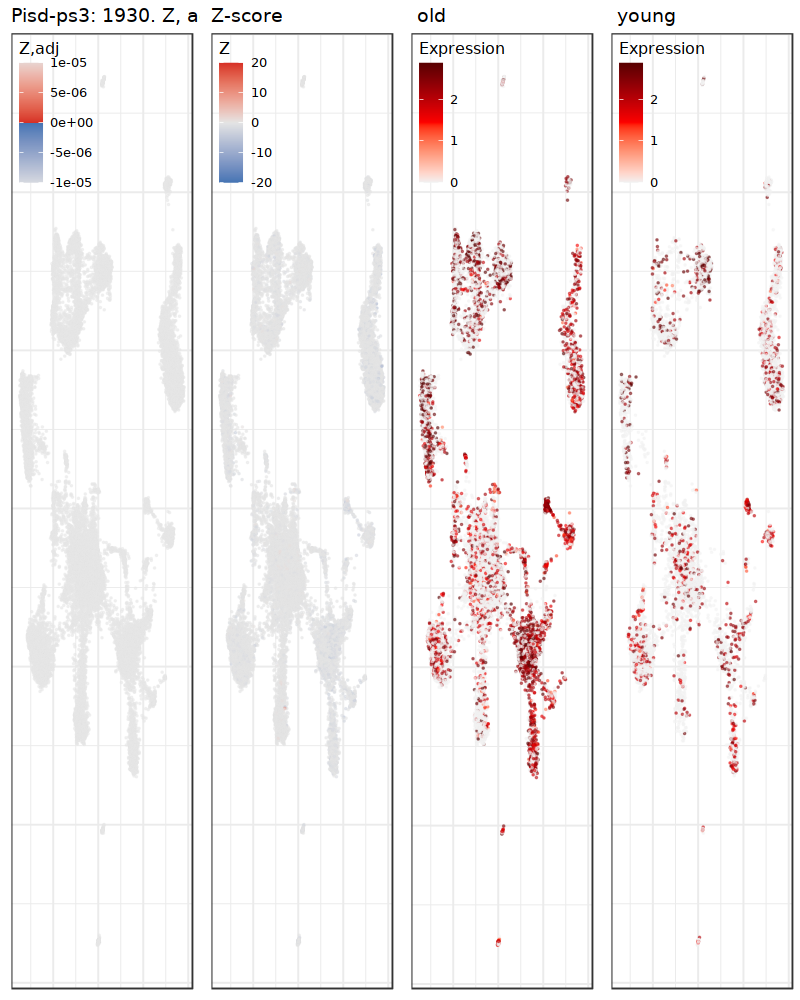

In [36]:
p1[[5]]

In [37]:
#cao_obj$estimateGenePrograms(n.programmes=10, n.sampled.cells=10000, cyc=1500)


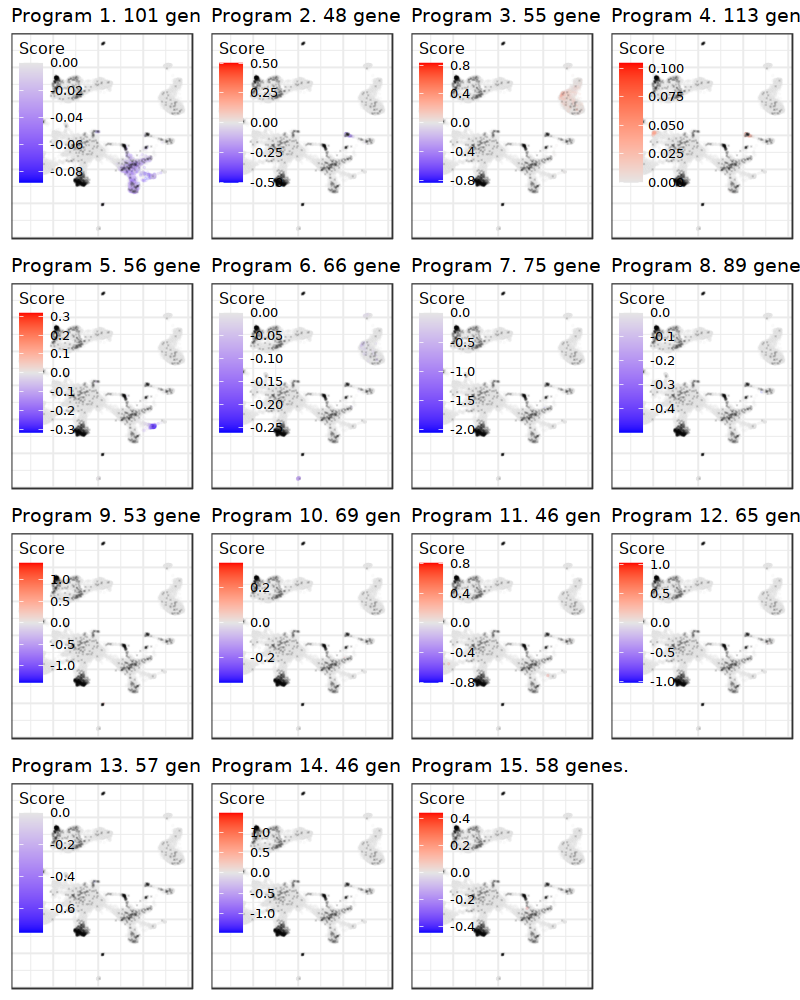

In [38]:
cao_obj$plotGeneProgramScores(legend.position=c(0, 1), size=0.1, alpha=0.1)

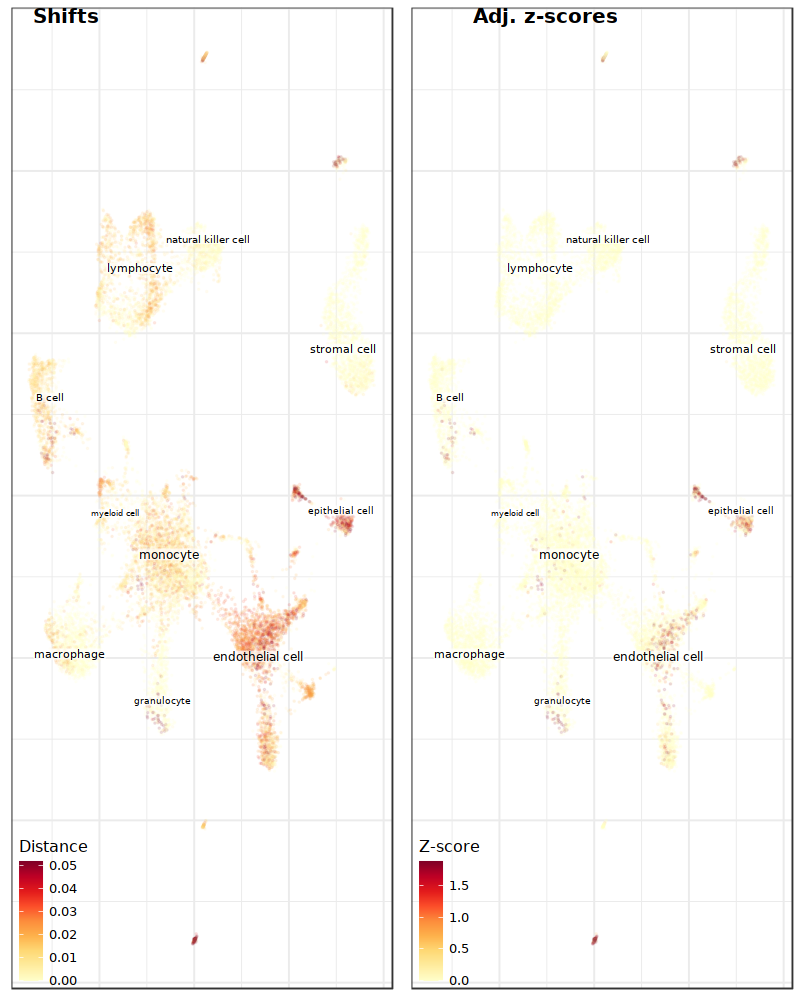

In [39]:
plot_grid(
  cao_obj$plotClusterFreeExpressionShifts(size=0.1, alpha=0.1, legend.position=c(0, 0), font.size=c(2,3))
)

In [40]:
#cao_obj$plotGeneProgramGenes(program.id = 1)

## Differential Gene Expression Analysis

Here 4 Different Methods were used for DE nalysis:
- de: DESE2 with Bootstrapping 
- de.Fixed <- Fixed cell number (50), bootstrapped
- de.loo <- loo resampling method
- de.fix <- DESeq2 fix.count resampling

In [41]:

create_DE_plots <- function(de_type, cao_obj) {
    p_list <- list()
    p_list[["de_ncell"]] <-  cao_obj$plotDEGenes(name = de_type) + ggtitle(de_type)
    p_list[["plot_volcano"]] <- cao_obj$plotVolcano(xlim=c(-3,3), ylim=c(0,3), lf.cutoff = 1, name = de_type)
    p_list[["nDEgenes"]] <- cao_obj$plotNumberOfDEGenes(name=de_type,pvalue.cutoff=1e-3, p.adjust=FALSE,
                        show.jitter=FALSE, type='box', show.resampling.results=TRUE)
    #p_list[["stab"]] <- cao_obj$plotDEStabilityPerCellType(sort.order=T, de.name = de_type)
    p_list
}
plots <- lapply(list("de.Wald", "deFixed_LRT", "de.loo", "de.fix"), create_DE_plots, cao_obj = cao_obj )

Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 41 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 44 rows containing missing values (geom_point).”
Warning message:
“Removed 96 rows containing missing values (geom_point).”
Warning message:
“Removed 34 rows containing missing values (geom_point).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”
Warn

Warning message:
“Removed 3 rows containing missing values (geom_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


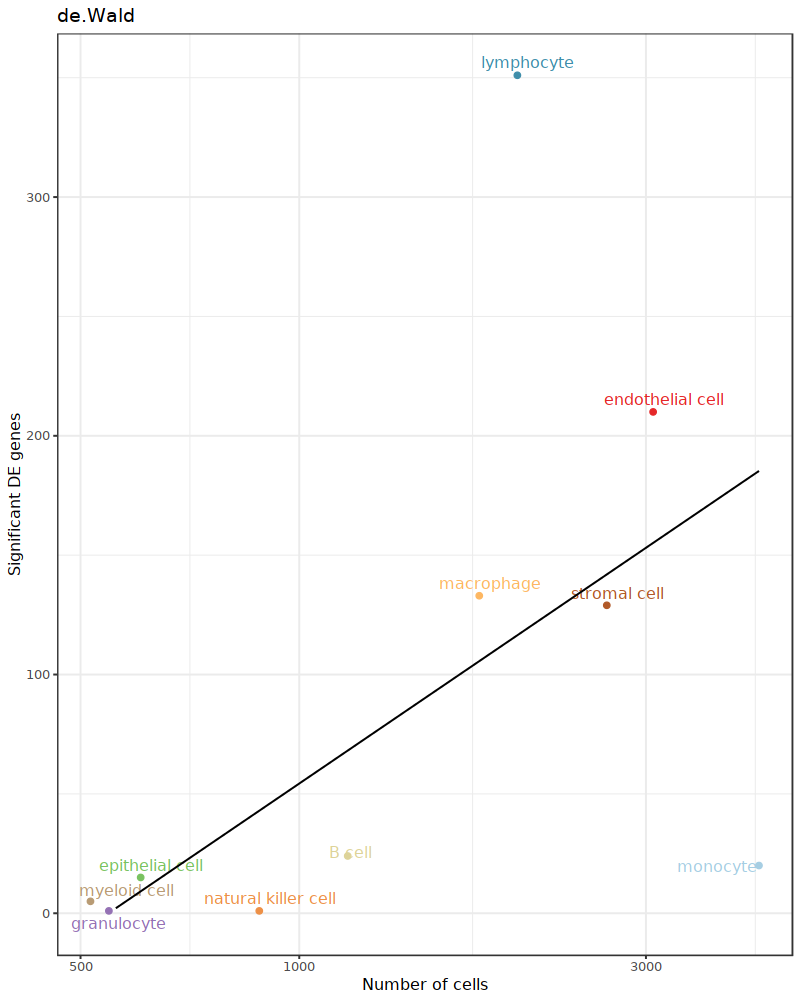

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.



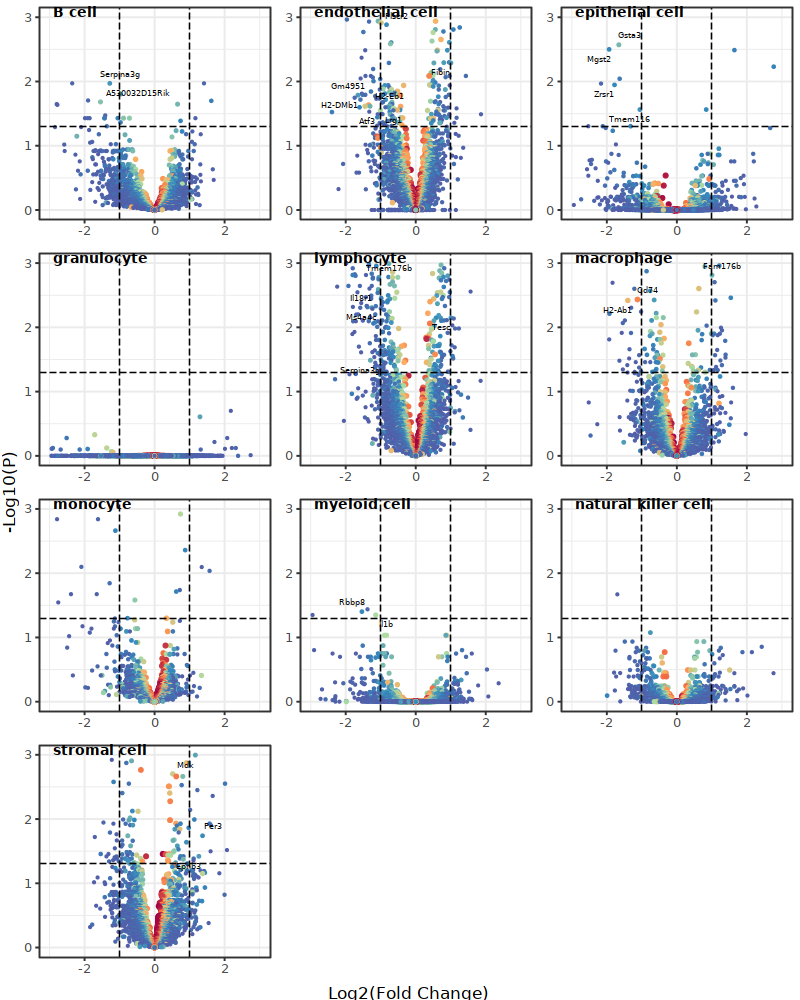

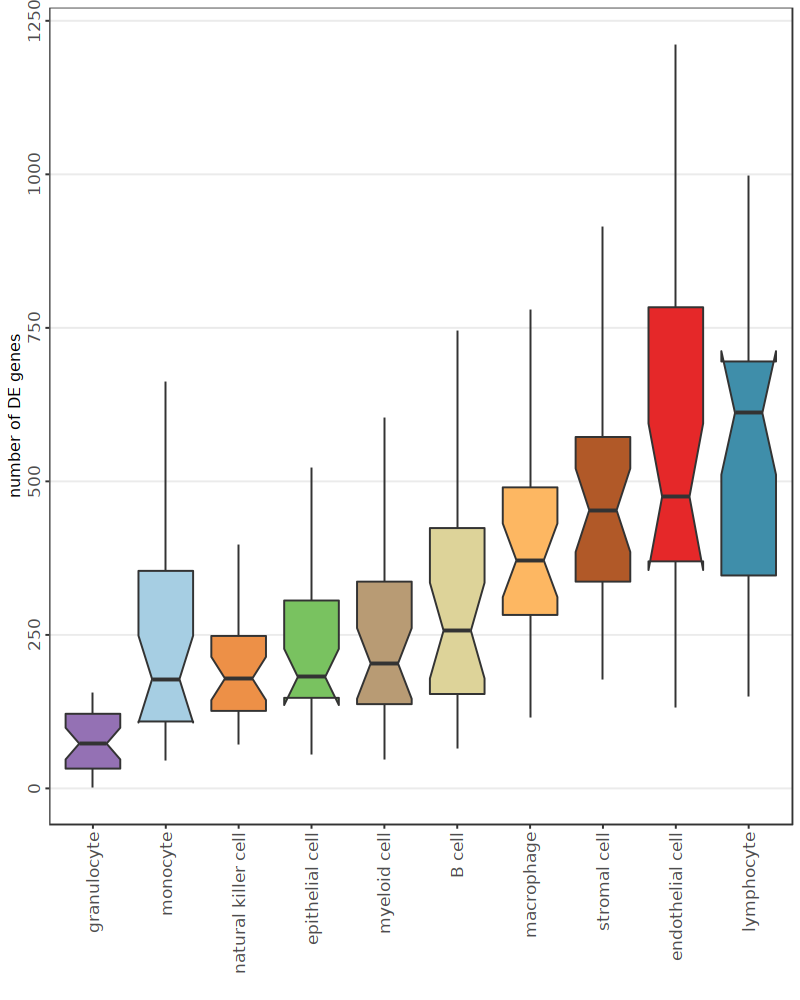

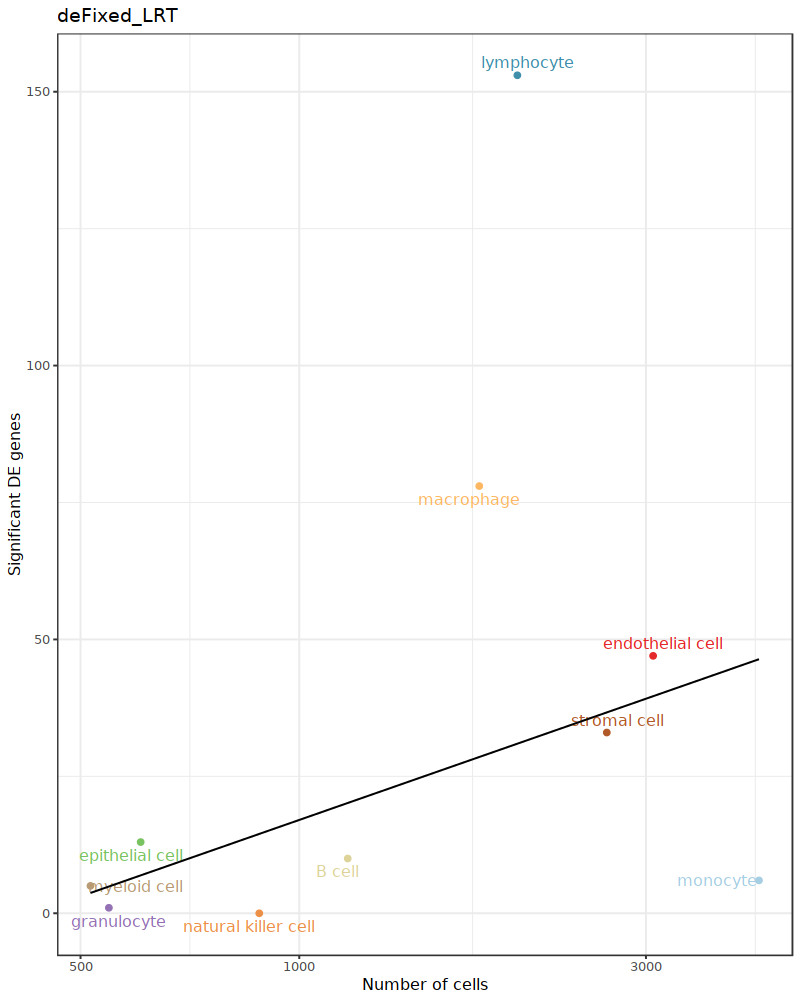

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.



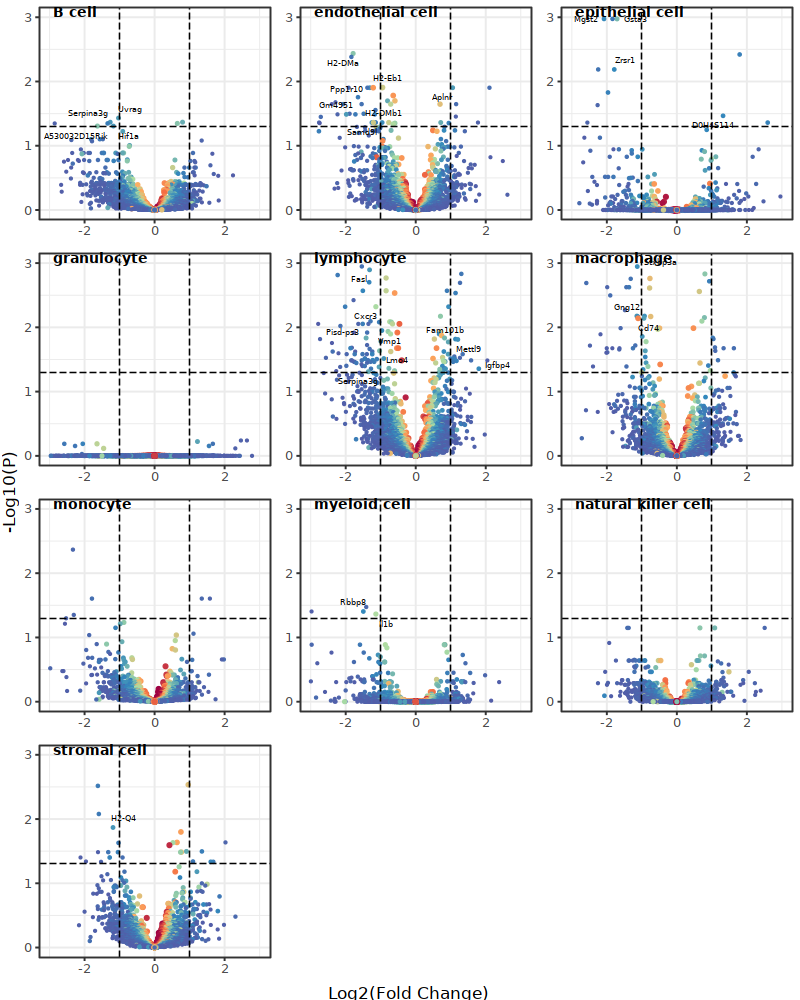

Warning message:
“Removed 3 rows containing missing values (geom_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


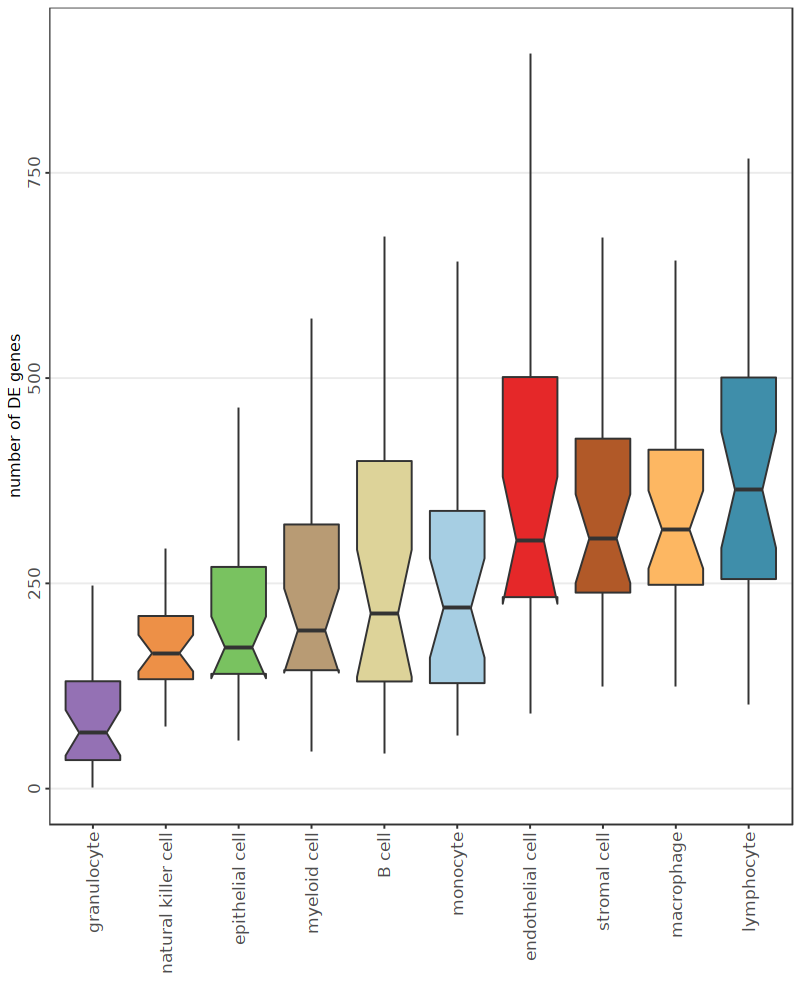

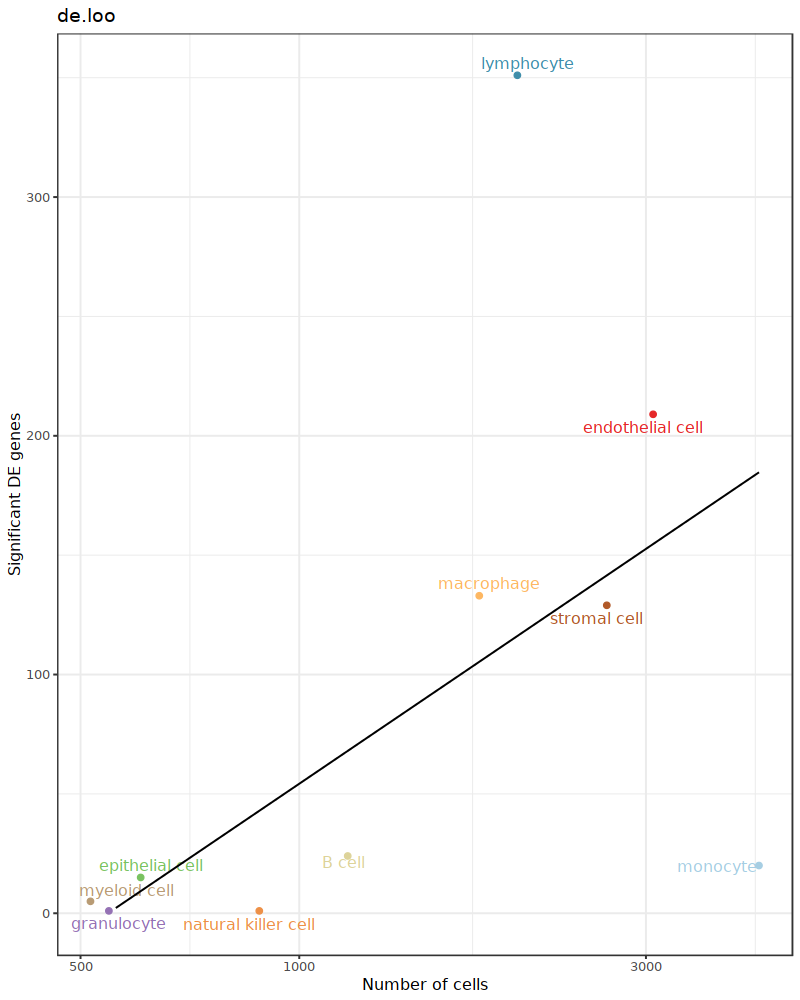

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.



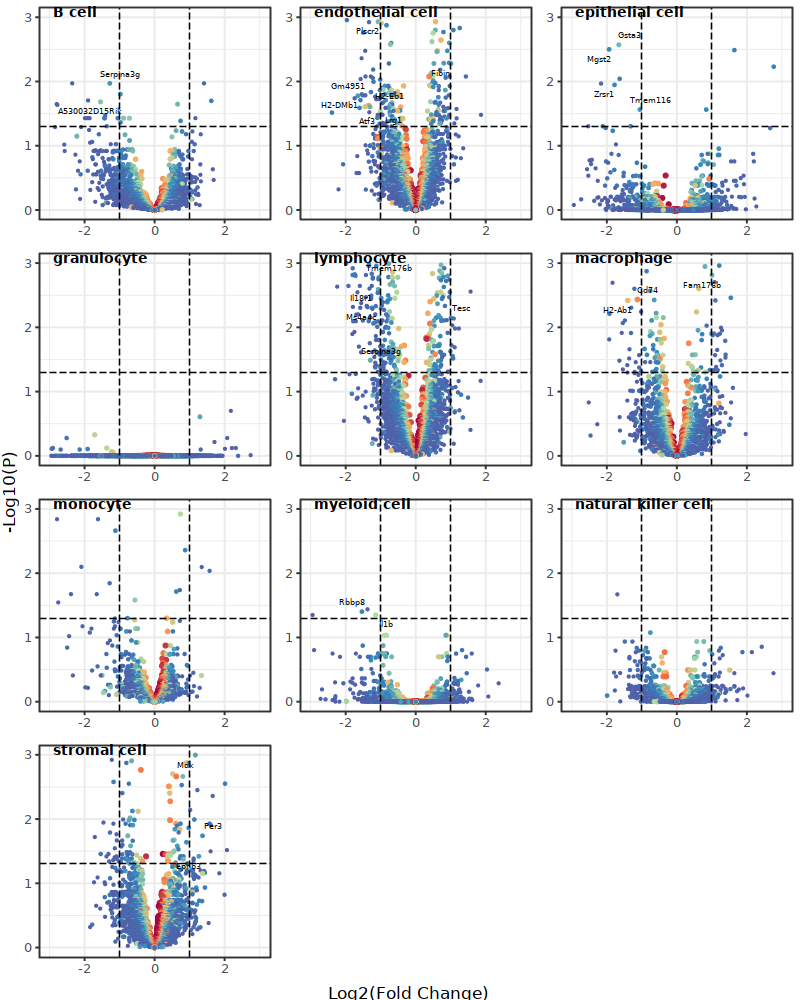

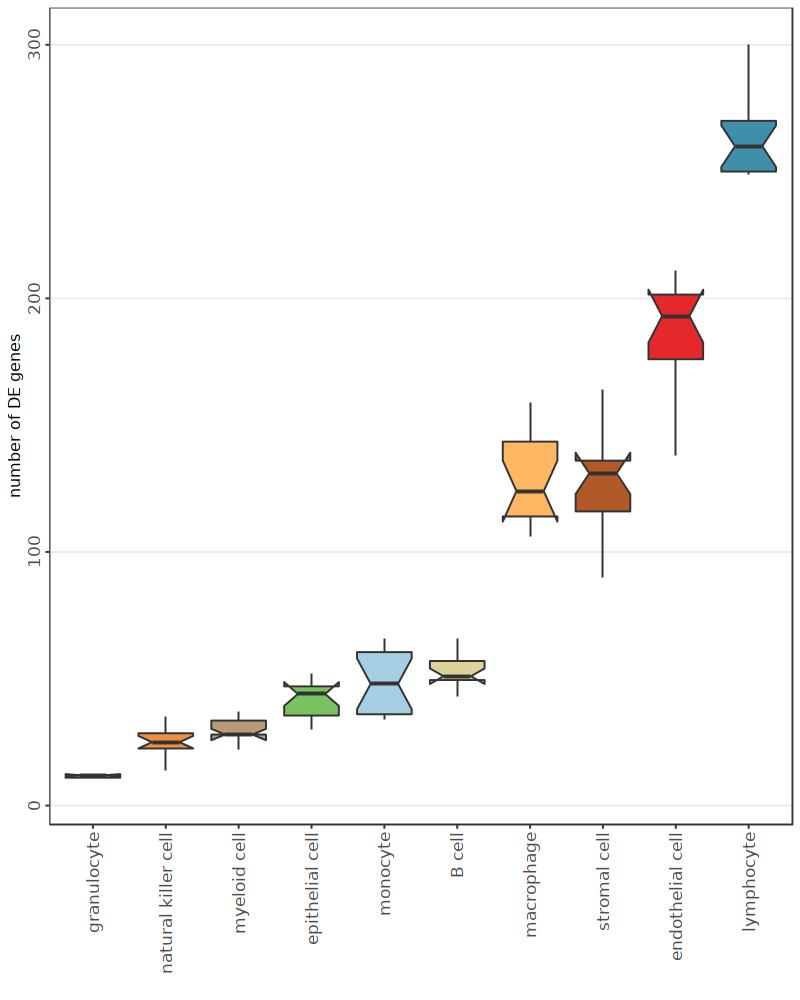

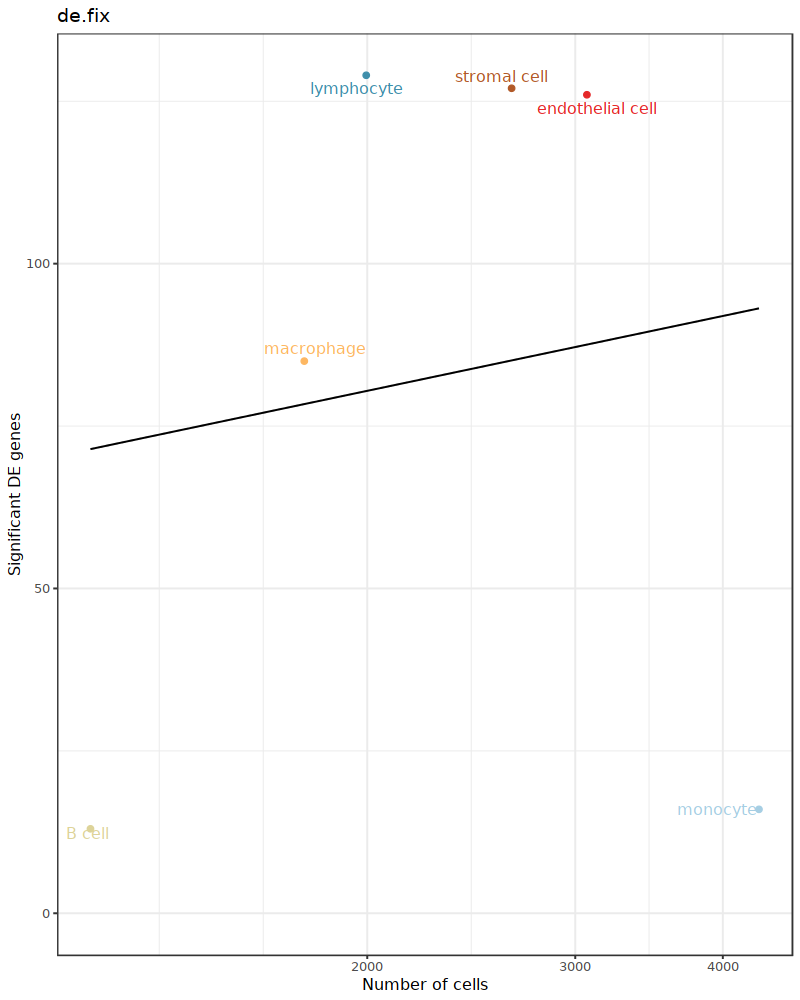

[[1]]
[[1]]$de_ncell

[[1]]$plot_volcano

[[1]]$nDEgenes


[[2]]
[[2]]$de_ncell

[[2]]$plot_volcano

[[2]]$nDEgenes


[[3]]
[[3]]$de_ncell

[[3]]$plot_volcano

[[3]]$nDEgenes


[[4]]
[[4]]$de_ncell

[[4]]$plot_volcano

[[4]]$nDEgenes



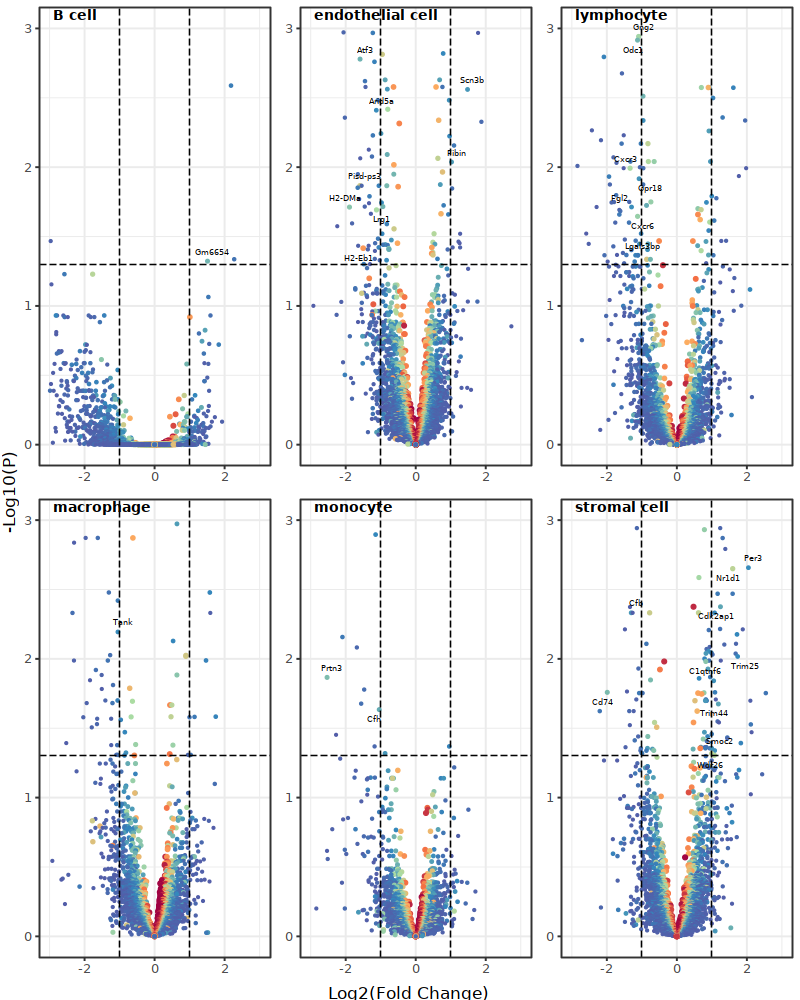

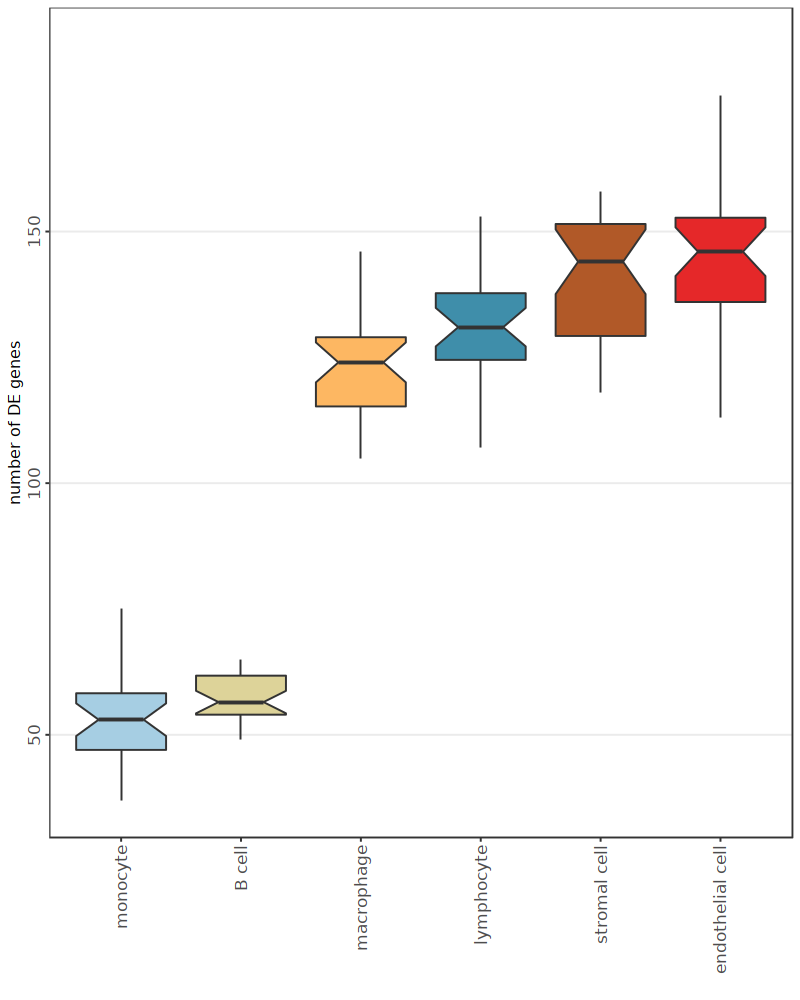

In [42]:
plots

In [43]:
cao_obj$test.results$de.loo$`endothelial cell`$res %>% dplyr::filter(padj < 0.05)


baseMean  log2FoldChange lfcSE      stat      pvalue      
Gypc           46.51623  1.6258910     0.24094191  6.748062 1.498328e-11
Tbxa2r        161.84499  1.3014515     0.19413371  6.703892 2.029401e-11
Csprs          73.96240 -5.0574510     0.75755048 -6.676058 2.454548e-11
Abcg1          88.15855  0.8276274     0.12922656  6.404468 1.508943e-10
Mal            74.67061 -1.6194435     0.25699552 -6.301446 2.948806e-10
H2-DMa        137.99176 -2.0687328     0.34658244 -5.968949 2.387872e-09
Arid5a        105.42445 -1.1216399     0.19415011 -5.777179 7.596350e-09
Col5a2         46.19479  1.5232300     0.27153776  5.609643 2.027440e-08
Casp4          66.21888 -1.1828912     0.21355989 -5.538920 3.043425e-08
Frrs1          57.68395  1.5010658     0.27102148  5.538549 3.049879e-08
Prss23        272.95084 -0.8631339     0.15595878 -5.534372 3.123455e-08
Tspan12       399.69836  0.4314908     0.07878209  5.477016 4.325580e-08
Enpp2         114.18268  0.8856301     0.16242481  5.452555 4.965133e-08
Adamts1       291.45485 -0.7059111     0.12994996 -5.432176 5.567088e-08
Tspan4        204.01405  0.8206529     0.15406221  5.326763 9.997825e-08
Mest          164.65727  1.6052899     0.30209638  5.313834 1.073426e-07
Ntrk2         166.06098 -1.1894321     0.22409110 -5.307806 1.109527e-07
Slc6a6        143.20831 -0.7440904     0.14379963 -5.174495 2.285286e-07
St3gal2       150.18371  0.7725152     0.14995375  5.151690 2.581496e-07
Nlgn2          83.87352 -1.5838890     0.30844431 -5.135089 2.820106e-07
Dbp            74.19652  3.3572589     0.66861383  5.021223 5.134363e-07
Fam176b       263.35415  0.5443684     0.11072987  4.916184 8.824739e-07
Nkd2          148.80726 -1.6002142     0.32617339 -4.906023 9.294161e-07
Pf4            32.45200 -4.2432437     0.86654121 -4.896759 9.743009e-07
Ntn1          214.64728 -0.7392230     0.15136598 -4.883680 1.041240e-06
Ppic          247.31037  0.5889398     0.12077543  4.876321 1.080824e-06
Pvrl3         197.38264  0.9366328     0.19215760  4.874295 1.091979e-06
Zfp758         63.98248 -1.4188092     0.29186608 -4.861165 1.166969e-06
Eln           143.59706  0.6117781     0.12616708  4.848952 1.241154e-06
Oas2           68.91064 -1.7009089     0.35250207 -4.825245 1.398311e-06
⋮             ⋮         ⋮              ⋮          ⋮         ⋮           
9030224M15Rik 124.70414  0.7050538     0.2105566   3.348524 0.0008124314
Neat1         176.77973 -0.3716108     0.1110717  -3.345684 0.0008208000
Yaf2          157.26041  0.3672380     0.1100208   3.337895 0.0008441560
Rnf145        136.44855  0.4067816     0.1219669   3.335180 0.0008524419
Zfp938         59.27613 -0.6616175     0.1985850  -3.331659 0.0008633008
Ptp4a3        242.79159  0.5019620     0.1507938   3.328799 0.0008722142
Glcci1         95.42726 -0.6022308     0.1809568  -3.328036 0.0008746069
Plekha1       146.22022  0.4043574     0.1215124   3.327705 0.0008756441
Lrrc8a        278.80763  0.4234886     0.1272994   3.326714 0.0008787659
Plat          202.03966 -0.6292073     0.1891672  -3.326197 0.0008803953
Golga4        101.02927 -0.6475585     0.1951859  -3.317650 0.0009077828
Lipe          184.06721 -0.6878527     0.2076204  -3.313031 0.0009229075
Gdpd5          93.75350  0.6852644     0.2069499   3.311256 0.0009287804
Zfp869         84.79221 -0.6790617     0.2050843  -3.311135 0.0009291838
1700029G01Rik  74.46870  0.7528670     0.2276536   3.307073 0.0009427617
Gnb4          156.48696  0.5009234     0.1518311   3.299214 0.0009695599
Golm1          76.86861 -0.8053831     0.2444667  -3.294450 0.0009861460
Tns3          109.12805  0.7167593     0.2186283   3.278439 0.0010438308
Hoga1         117.71439 -0.9408473     0.2872229  -3.275670 0.0010541172
Bcl6b         282.25928 -0.4462455     0.1362943  -3.274133 0.0010598683
Sltm          106.98356 -0.5119507     0.1563852  -3.273652 0.0010616733
Fkbp11         63.96327  1.1032187     0.3376214   3.267621 0.0010845556
Enho          241.20255  0.6847656     0.2097773   3.264251 0.0010975395

In [44]:
cao_obj$test.results$de.loo$`endothelial cell`$res["Aplnr",]

baseMean log2FoldChange lfcSE   stat     pvalue       padj       
Aplnr 297.7944 0.8012063      0.19505 4.107698 3.996225e-05 0.005188224
      Z        Za       stab.median.rank stab.mean.rank stab.var.rank Gene 
Aplnr 4.107698 2.795109 78               94.13333       2484.41       Aplnr
      CellFrac  SampleFrac
Aplnr 0.2447051 1

In [45]:
cao_obj$test.results$de.loo$`endothelial cell`$res["Apln",]

baseMean log2FoldChange lfcSE     stat     pvalue       padj        
Apln 248.7232 1.080775       0.2248175 4.807343 1.529494e-06 0.0004099538
     Z        Za       stab.median.rank stab.mean.rank stab.var.rank Gene
Apln 4.807343 3.533592 31               34.8           181.1714      Apln
     CellFrac  SampleFrac
Apln 0.2059303 1